## Step 14: Reanalysis of human single-nucleus RNA-seq data from Absinta et al and Schirmer et al

Now we'll reanalyze the human single-nucleus RNA-seq data shown in in Lee et al's Figure 5, which is a combination of two previously published datasets from [Absinta et al 2021 (PMID: 34497421)](https://pubmed.ncbi.nlm.nih.gov/34497421/) and [Schirmer et al 2019 (PMID: 31316211)](https://pubmed.ncbi.nlm.nih.gov/31316211/).

In [1]:
library(Seurat)
library(readxl)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(tidyr)
library(viridis)
library(presto)
library(orthogene)
library(ComplexHeatmap)
library(dendextend)
library(seriation)
library(ggrepel)
library(grid)
library(Matrix)
library(svglite)
library(harmony)
library(cowplot)
library(ggrastr)
setwd('..') # change working directory to 'EpiMemAstros' folder, adjust as needed

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps

First, read in the Seurat object from the previous step:

In [2]:
human <- readRDS('outputs/combined_human_seurat_object.rds')
human

An object of class Seurat 
91241 features across 16276 samples within 2 assays 
Active assay: RNA (61992 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, harmony, umap

This object already contains the UMAP dimension reduction shown in the original manuscript's Figure 5A.

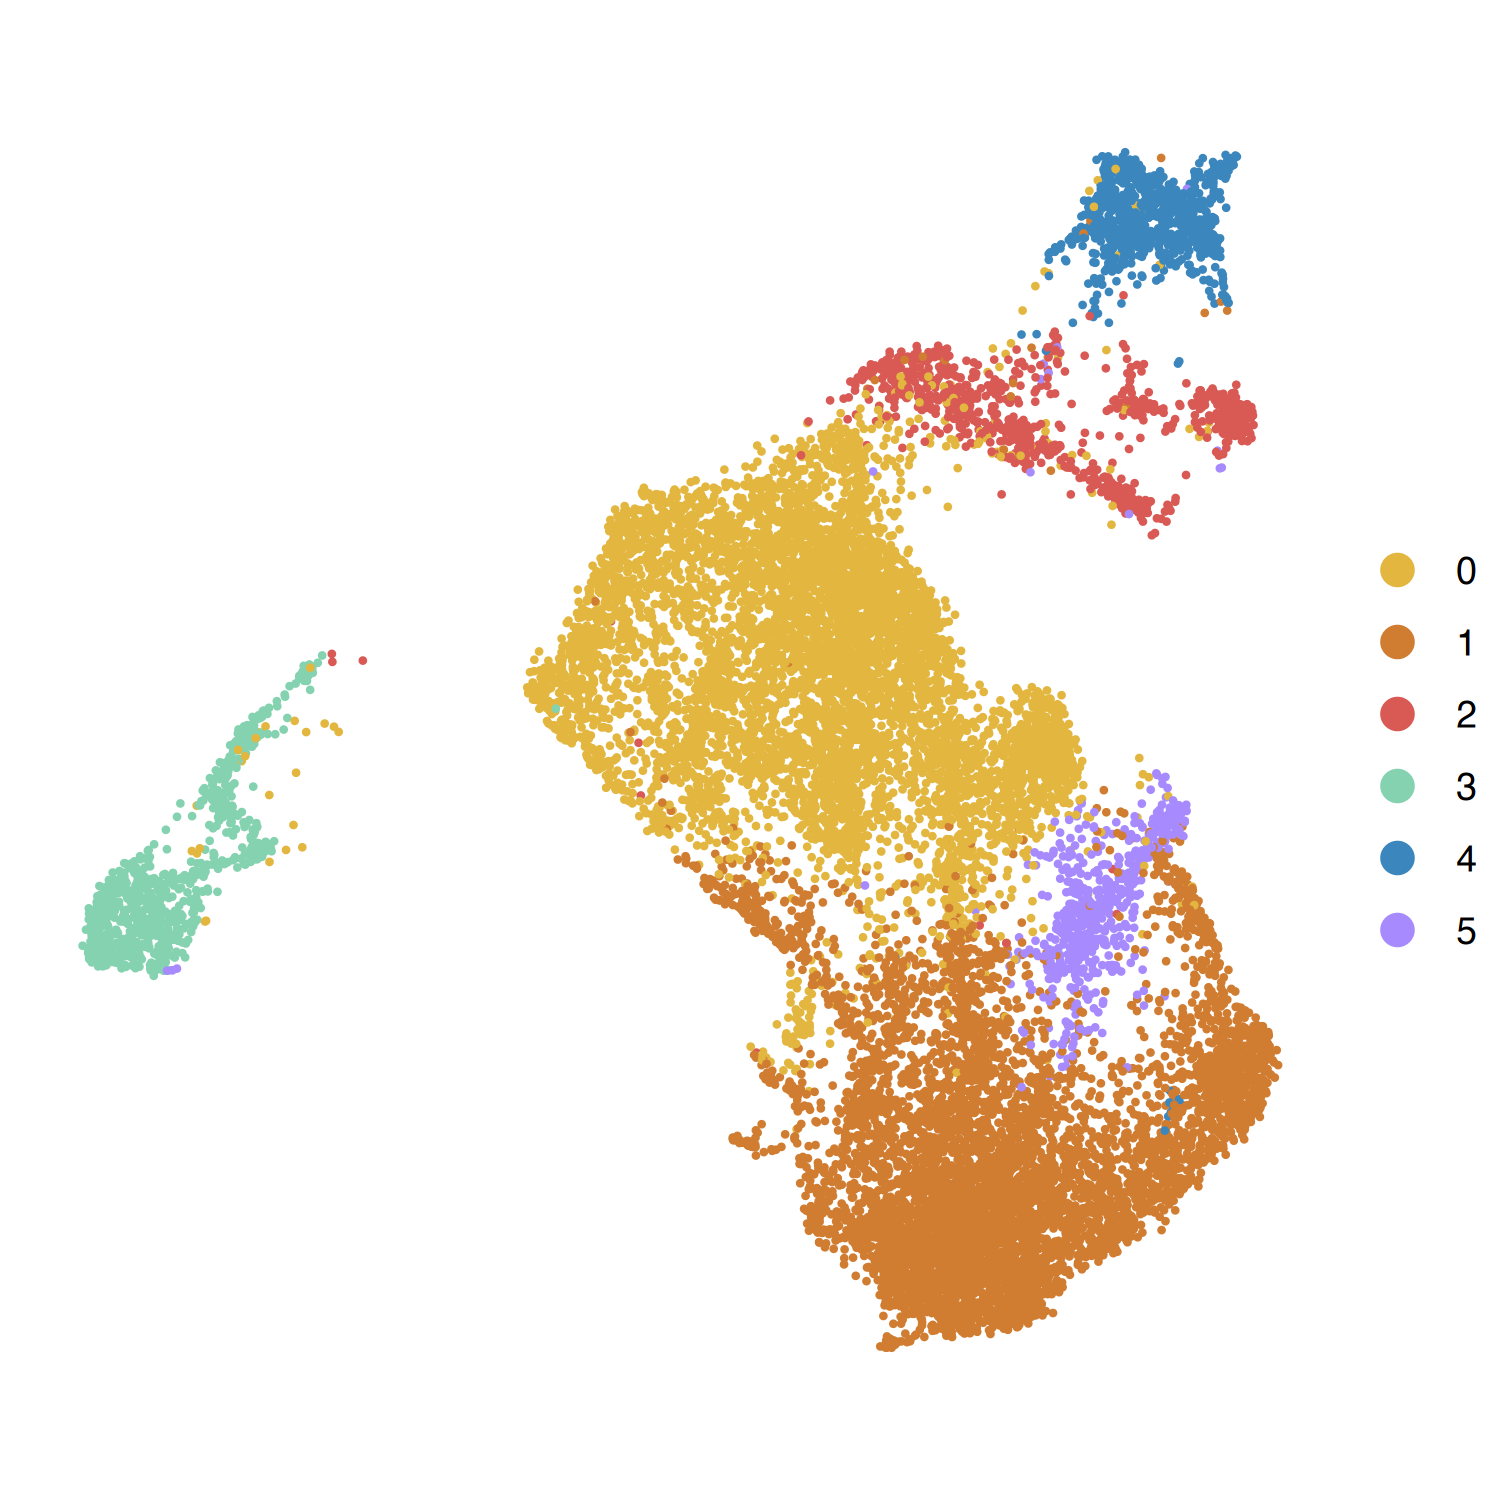

In [3]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 300)
image <- DimPlot(human, group.by = "seurat_clusters") + 
    scale_color_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + labs(title = NULL) + theme_void() + 
    theme(aspect.ratio = 1) + NoLegend()

ggsave(file="outputs/figures/figure3a.png", plot=image, width=5, height=5, dpi = 600)

image <- DimPlot(human, group.by = "seurat_clusters") +  
    scale_color_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + labs(title = NULL) + theme_void() + 
    theme(aspect.ratio = 1)

legend <- ggpubr::get_legend(image)

ggsave(file="outputs/figures/figure3a_legend.svg", plot=legend, width=5, height=5)

image

Next we'll add a metadata field to the Seurat object which indicates the dataset of origin for each nucleus.

In [4]:
human$source <- data.frame('source' = human$DataSource) %>% 
    mutate(source2 = ifelse(is.na(source), 'Absinta et al 2021', 
                            ifelse(source == 'Schirmer_2019', 'Schirmer et al 2019', source))) %>% .$source2

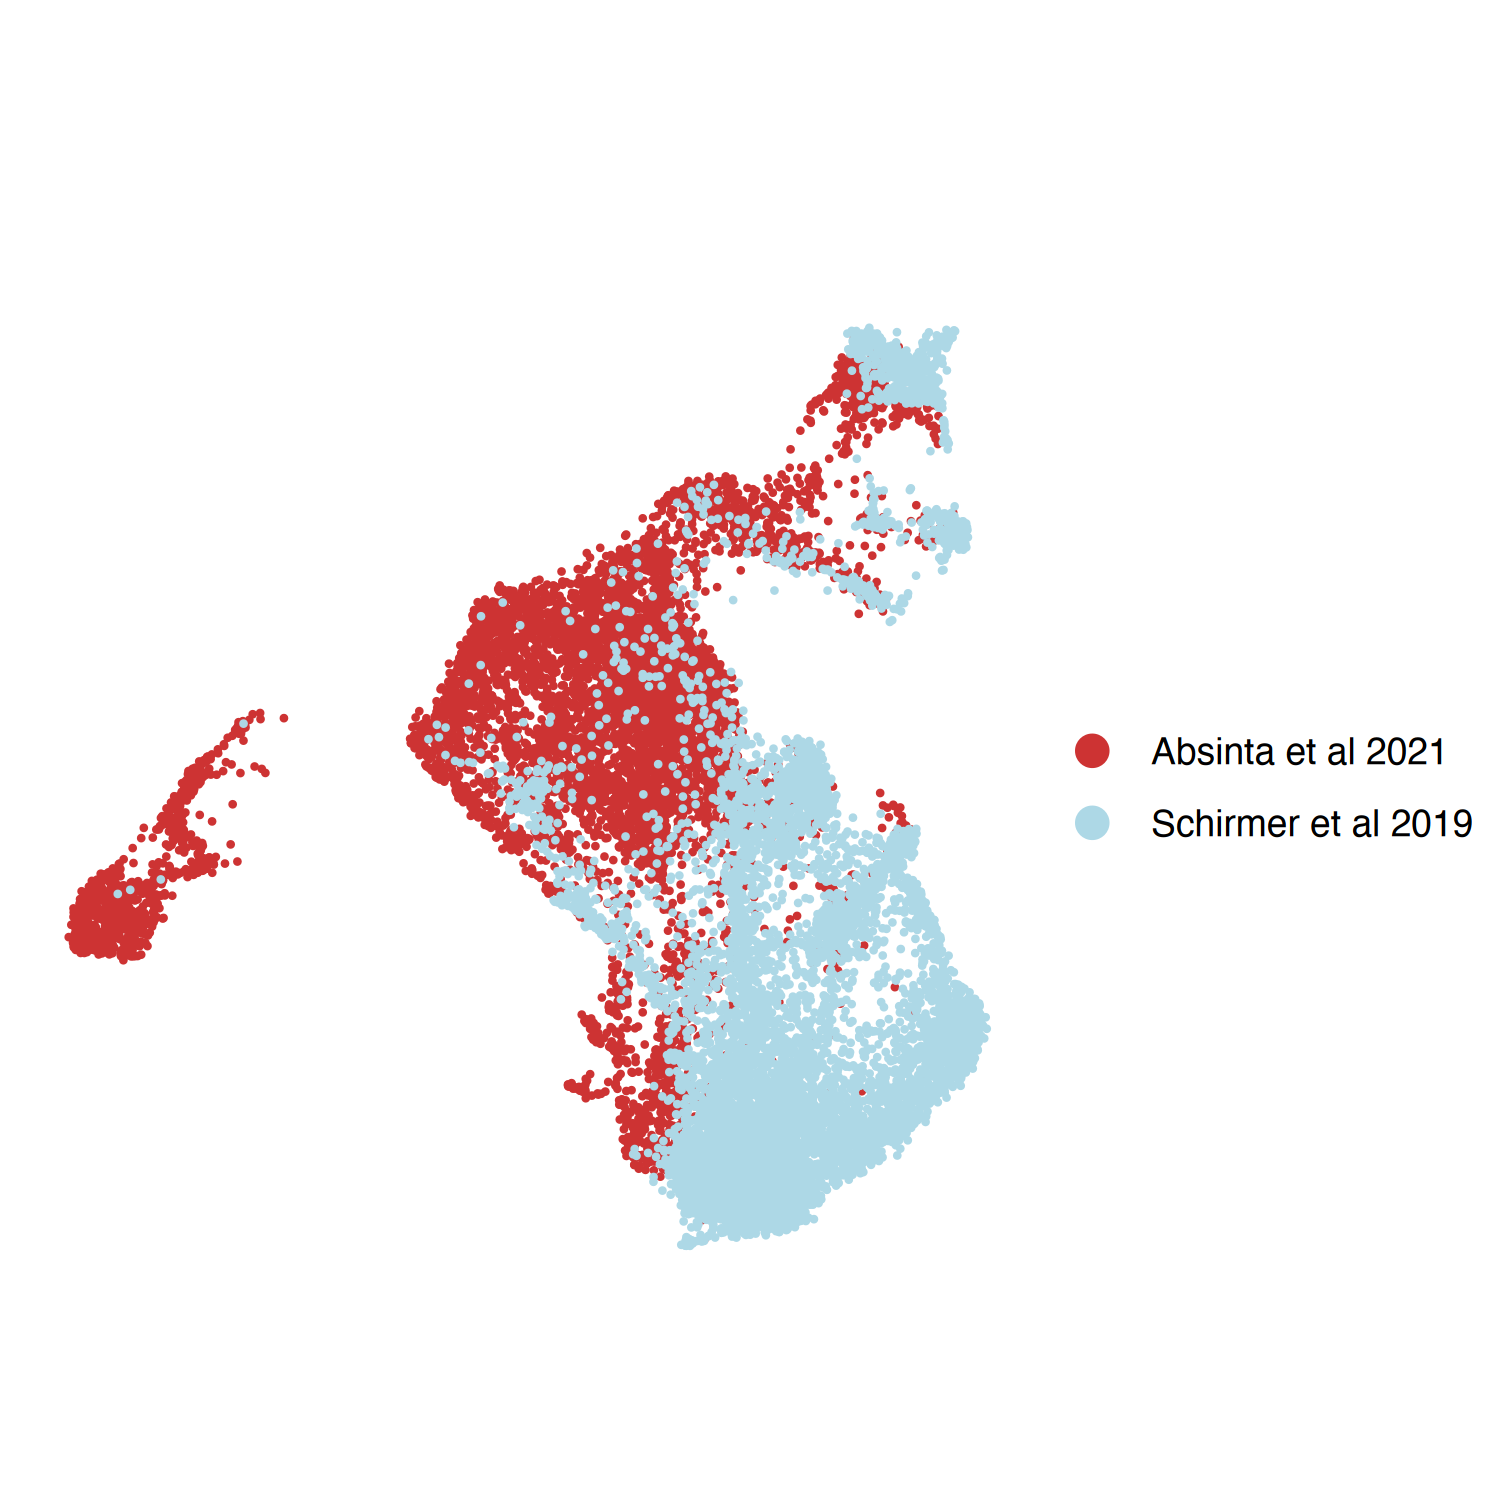

In [5]:
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res = 300)
image <- DimPlot(human, group.by = "source") + scale_color_manual(values = c('brown3', 'lightblue')) + theme_void() + 
    theme(aspect.ratio = 1) + labs(title = "") + NoLegend()

ggsave(file="outputs/figures/figure3a_dataset.png", plot=image, width=5, height=5, dpi=600)

image <- DimPlot(human, group.by = "source") + scale_color_manual(values = c('brown3', 'lightblue')) + theme_void() + 
    theme(aspect.ratio = 1) + labs(title = "")

legend <- ggpubr::get_legend(image)

ggsave(file="outputs/figures/figure3a_dataset_legend.svg", plot=legend, width=5, height=5)

image

We next calculate several common quality control metrics for each single nucleus and add them as metadata fields in the Seurat object: the percentage of UMIs mapping to the mitochondrial genome, the percentage of UMIs corresponding to ribosomal genes, and the nuclear fraction statistic (which we calculated in Step 13).

In [6]:
human[["percent.mt"]] <- PercentageFeatureSet(object = human, pattern = "^MT-")
human[['percent.ribo']] <- PercentageFeatureSet(human, pattern = '^RP[SL]')

We'll load the nuclear fractions data frames provided in the Zenodo repository. If you obtained the Cell Ranger BAM files and ran the nuclear fraction calculations in Step 13 yourself, replace the first line in the following code cell with the commented out line.

In [7]:
nuc_df = rbind(readRDS('inputs/zenodo/absinta_nuclear_fraction_df.rds'), readRDS('inputs/zenodo/schirmer_nuclear_fraction_df.rds'))
#nuc_df = rbind(readRDS('outputs/absinta_nuclear_fraction_df.rds'), readRDS('outputs/schirmer_nuclear_fraction_df.rds'))

human$nuc_fraction <- nuc_df[colnames(human), ]

Next we calculate enrichment scores for the memory astrocyte Up-Signature and the FIND-seq derived gene signature in each nucleus using the same AddModuleScore method used by Lee et al.

We'll calculate enrichment for both the corrected and un-corrected Up-Signature gene sets:

In [8]:
# uncorrected up-signature
signatures = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_signature = signatures %>% filter(log2FoldChange > 0) %>% .$gene

# corrected up-signature
IL1bTNF_2x_vs_1x = read.csv('inputs/zenodo/2x.IL1B.and.TNF.vs.1x.IL1B.dge.tsv', sep = '\t')
IL1bTNF_2x_vs_PBS = read.csv('inputs/zenodo/IL1B.and.TNF.vs.PBS.SPF.2X.dge.tsv', sep = '\t')
sig_IL1bTNF_2x_vs_1x = IL1bTNF_2x_vs_1x %>% filter(abs(log2FoldChange) > 1.5) %>% filter(padj < 0.05)
up_IL1bTNF_2x_vs_PBS = IL1bTNF_2x_vs_PBS %>% filter(log2FoldChange > 1) %>% filter(padj < 0.05)
corrected_upsignature = sig_IL1bTNF_2x_vs_1x %>% filter(log2FoldChange > 1.5) %>% filter(gene %in% rownames(up_IL1bTNF_2x_vs_PBS)) %>% .$gene

Because the original gene signature was composed of mouse genes, we need to create a list of orthologous human genes to evaluate enrichment in this human dataset. According to our correspondence with the authors, the original manuscript attempted to convert from mouse to human orthologs simply by capitalizing the gene names. While this works for many genes, this does not properly account for orthologous genes with differing names, as well as one-to-many or many-to-one orthologs. We use a more robust approach for converting mouse gene names to human orthologs, using the `convert_orthologs` function from the `orthogene` package, and retain only one-to-one orthologs between mouse and human. We will also calculate enrichment scores using the capitalization method of the original authors for comparison's sake.

In [9]:
upsig_ortho_genes <- convert_orthologs(up_signature, input_species = "mouse", output_species = 'human', non121_strategy = "drop_both_species")
human_up_signature <- rownames(upsig_ortho_genes)

Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

1,105 genes extracted.

Converting mouse ==> human orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: mmusculus

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: hsapiens

Checking for genes without orthologs in human.

Extracting genes from input_gene.

1,195 genes extracted.

Extracting genes from ortholog_gene.

1,195 genes extracted.

Dropping 140 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Dropping 69 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 50 genes that have multiple ortholog_gene per input_gene (1:many).

Filterin

In [10]:
corrected_upsig_ortho_genes <- convert_orthologs(corrected_upsignature, input_species = "mouse", output_species = 'human', non121_strategy = "drop_both_species")
human_corrected_up_signature <- rownames(corrected_upsig_ortho_genes)

Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

91 genes extracted.

Converting mouse ==> human orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: mmusculus

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: hsapiens

Checking for genes without orthologs in human.

Extracting genes from input_gene.

111 genes extracted.

Extracting genes from ortholog_gene.

111 genes extracted.

Dropping 11 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Dropping 18 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 9 genes that have multiple ortholog_gene per input_gene (1:many).

Filtering gene_df

Lastly, we'll use the authors capitalization method for comparison:

In [11]:
cap_up_signature <- toupper(up_signature)
cap_corrected_up_signature <- toupper(corrected_upsignature)

We repeat this process for the FIND-seq signature, loading the gene list from Lee et al's Supplementary Table 9.

In [12]:
findseq = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM10_ESM.xlsx', col_names = FALSE)
findseq = findseq$`...1`
findseq_ortho_genes <- convert_orthologs(findseq, input_species = "mouse", output_species = 'human', non121_strategy = "drop_both_species")
findseq_human <- rownames(findseq_ortho_genes)

New names:
• `` -> `...1`
Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

661 genes extracted.

Converting mouse ==> human orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: mmusculus

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: hsapiens

Checking for genes without orthologs in human.

Extracting genes from input_gene.

696 genes extracted.

Extracting genes from ortholog_gene.

696 genes extracted.

Dropping 135 NAs of all kinds from ortholog_gene.

Checking for genes without 1:1 orthologs.

Dropping 22 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 3 genes that have multiple ortholog_gene per input_gene 

In [13]:
cap_findseq <- toupper(findseq)

Next, we run AddModuleScore to calculate enrichment of each gene set, and save the gene sets for use in the Step 15 script.

In [14]:
human <- AddModuleScore(human, features = list(human_up_signature, human_corrected_up_signature, cap_up_signature, cap_corrected_up_signature, findseq_human, cap_findseq), name = 'SIGNATURE')
saveRDS(human_up_signature, 'outputs/human_up_signature.rds')
saveRDS(human_corrected_up_signature, 'outputs/human_corrected_up_signature.rds')
saveRDS(cap_up_signature, 'outputs/human_up_signature_capitalizationbased.rds')
saveRDS(cap_corrected_up_signature, 'outputs/human_corrected_up_signature_capitalizationbased.rds')
saveRDS(findseq_human, 'outputs/human_findseq_signature.rds')
saveRDS(cap_findseq, 'outputs/human_findseq_signature_capitalizationbased.rds')

Warning message:
“The following features are not present in the object: LY6S, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TRF, FTL1, AC160336.1, UBB-PS, LYZ2, H2-D1, GM15500, RPS3A1, RPL10-PS3, GM20186, TGOLN1, CAR12, ATP5G1, TPT1-PS3, GM10275, GM12840, PAKAP, GM10076, C1RA, GM48942, GM7536, TXN1, GM11808, LILR4B, RPS23-PS1, C1S1, H2-AB1, GM15501, ZFP266, AI506816, GM9973, RPL15-PS3, RPS12-PS3, ATPIF1, GM9794, ATP5E, GM10288, LILRB4A, HPRT, SAA3, IL4RA, GM29408, GM5641, PIRB, RPL28-PS1, RPS16-PS2, H2-T23, FCGR3, RPSA-PS10, CAR13, H2-AA, WFDC17, CD59A, OLFR1033, TGTP1, CYP4F18, CCL6, RPS7-PS3, CTPS, H2-EB1, ZFP185, GM20400, SLFN2, AB124611, SLFN4, SLCO1A4, TLR13, SIRPB1C, H2-DMB1, CCL9, BCL2A1B, LY6A, GM29371, H2-Q10, MS4A6D, SIRPB1B, TTC7, H2-DMA, CSF2RB2, GM37347, GM49339, CD300C2, ABCA8A, COX8B, H2-Q7, IL1F9, CBR2, MS4A6B, FYB, IL6RA, GM12505, GM48377, CLEC4A3, MS4A6C, GM47922, TRIM30B, IFI207, SIRPB1A, UGT1A7C, ZFP810, S

Next, we'll evaluate and compare the enrichment scores we calculated. We note that a metadata slot existed in the original Seurat object shared with us by Lee et al called `trained.up` which we believed to be the module score for the Up-Signature gene set. We include this metadata slot for our comparisons.

In [15]:
score_df = data.frame('authors_scores' = human$trained.up, 'original_upsig' = human$SIGNATURE1, 'corrected_upsig' = human$SIGNATURE2, 'cap_original_upsig' = human$SIGNATURE3, 'cap_corrected_upsig' = human$SIGNATURE4, 
                     'findseq' = human$SIGNATURE5, 'cap_findseq' = human$SIGNATURE6, 'seurat_clusters' = human$seurat_clusters)

First, let's evaluate how the score for each individual cell varies between our orthogene-based signatures and their corresponding capitalization-based signatures:

Warning message:
“The dot-dot notation (`..rr.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(rr.label)` instead.”


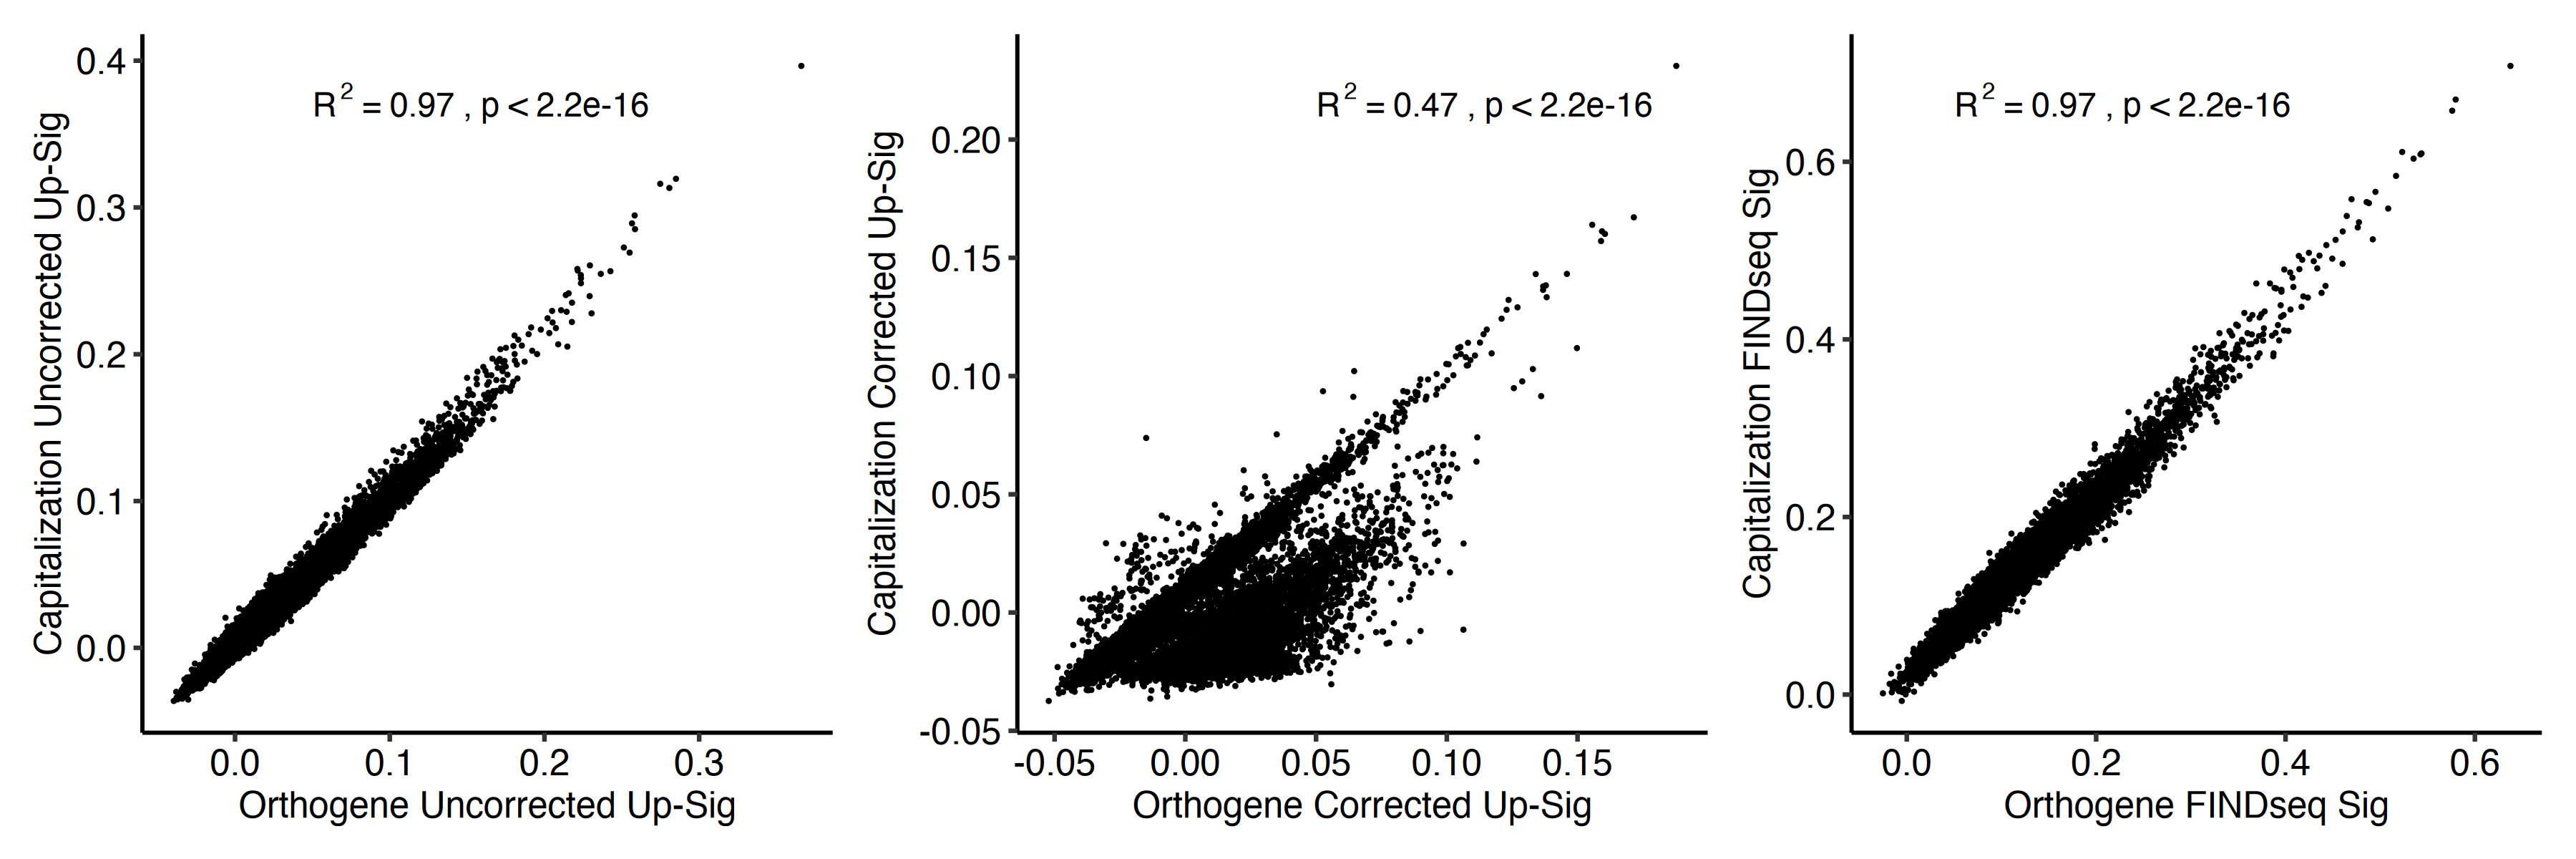

In [16]:
options(repr.plot.width=12, repr.plot.height=4, repr.plot.res = 300)
    p1 <- ggplot(data = score_df, aes(x = original_upsig, y = cap_original_upsig)) + 
        geom_point(size = 0.1) + 
        stat_cor(aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x = 0.05) + 
        labs(x = "Orthogene Uncorrected Up-Sig", y = 'Capitalization Uncorrected Up-Sig') + 
        theme_pubr()

    p2 <- ggplot(data = score_df, aes(x = corrected_upsig, y = cap_corrected_upsig)) + 
        geom_point(size = 0.1) + 
        stat_cor(aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x = 0.05) + 
        labs(x = "Orthogene Corrected Up-Sig", y = 'Capitalization Corrected Up-Sig') + 
        theme_pubr()

    p3 <- ggplot(data = score_df, aes(x = findseq, y = cap_findseq)) + 
        geom_point(size = 0.1) + 
        stat_cor(aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x = 0.05) + 
        labs(x = "Orthogene FINDseq Sig", y = 'Capitalization FINDseq Sig') + 
        theme_pubr()

    image <- p1 + p2 + p3

    ggsave(file="outputs/figures/capsbased_vs_orthogene_signature_scores.png", plot=image, width=12, height=4)

    image

We can see that the authors' method of simply capitalizing mouse gene names to convert to human orthologs results in highly similar cells scores for the uncorrected up-signature and FIND-seq derived signature gene sets; however, there is greater divergence with the corrected up-signature gene set, with the orthogene-based approach generating higher scores for a subset of cells compared to the capitalization-based scores. This is likely because the original, uncorrected up-signature and FIND-seq derived gene signature both contain hundreds of genes, so the failed conversion of a few genes with the capitalization-based approach doesn't change each cell's enrichment score very much. However, the corrected up-signature only contains 91 genes, only 71 of which had one-to-one orthologs. We can see from the warning messages printed when we run the `AddModuleScore` function that the capitalization-based approach led to a few more genes being not found in the Seurat object. The missing information from each of these dropped out genes will have a larger effect on each cell's score given the smaller size of the corrected gene set. 

For our purposes, we'll use the orthogene-based orthologs for each gene set as these are more accurate and result in a more complete ortholog gene list compared to the capitalization-based approach.

Now let's see how the authors' `trained.up` metadata slot compares to the scores we obtained for each single cell with the uncorrected and corrected up-signature gene sets. Because the authors used the capitalization-based approach, we'll use those genesets for our comparison here.

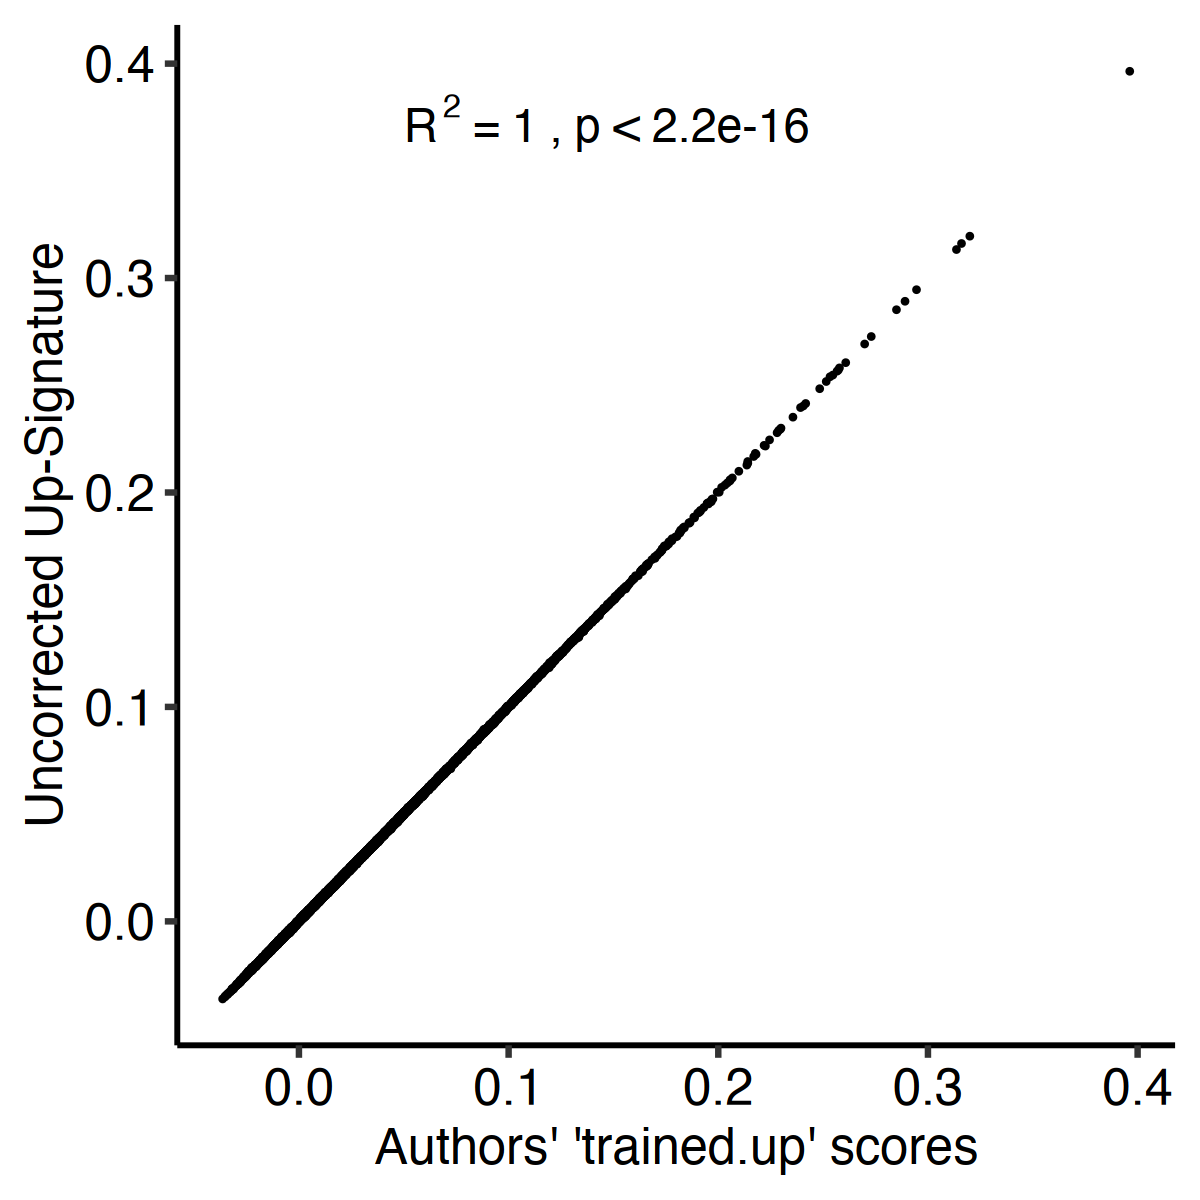

In [17]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res = 300)
    image <- ggplot(data = score_df, aes(x = authors_scores, y = cap_original_upsig)) + 
        geom_point(size = 0.1) + 
        stat_cor(aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x = 0.05) + 
        labs(x = "Authors' 'trained.up' scores", y = 'Uncorrected Up-Signature') + 
        theme_pubr()

    ggsave(file="outputs/figures/human_original_upsignature_vs_trainedup_scatterplot.png", plot=image, width=4, height=4)

    image

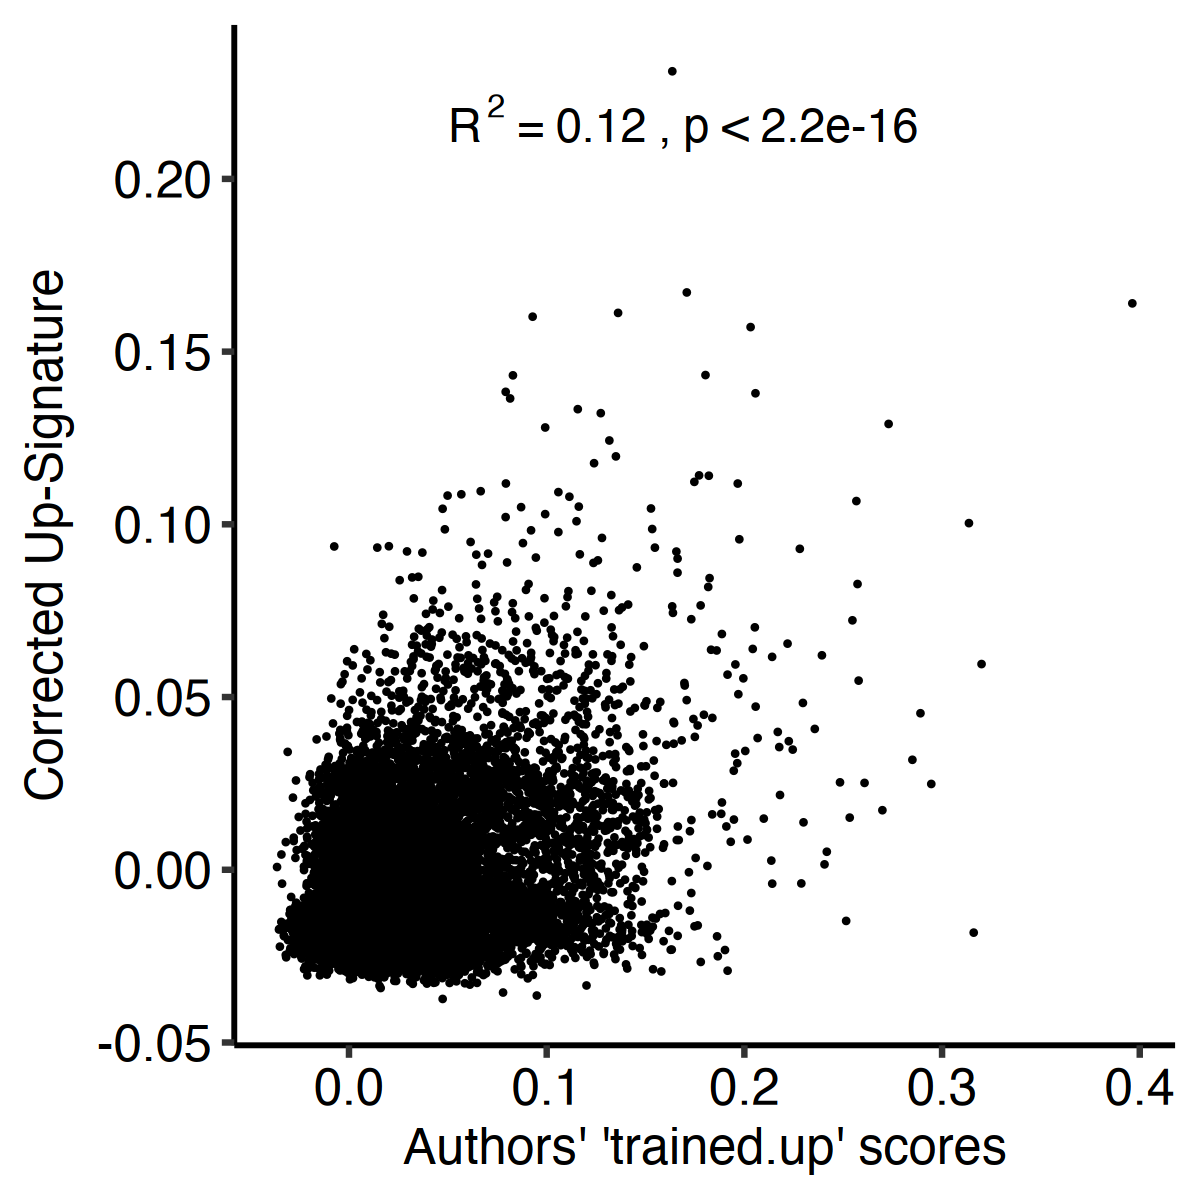

In [18]:
options(repr.plot.width=4, repr.plot.height=4, repr.plot.res = 300)
    image <- ggplot(data = score_df, aes(x = authors_scores, y = cap_corrected_upsig)) + 
        geom_point(size = 0.1) + 
        stat_cor(aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), label.x = 0.05) + 
        labs(x = "Authors' 'trained.up' scores", y = 'Corrected Up-Signature') + 
        theme_pubr()

    ggsave(file="outputs/figures/human_corrected_upsignature_vs_trainedup_scatterplot.png", plot=image, width=4, height=4)

    image

We can see the scores present in the 'trained.up' metadata slot are identical to those we obtain by running `AddModuleScore` on the original (uncorrected) up-signature gene set when using the authors' method of simply capitalizing the gene names from the mouse gene list. These scores are not identical to the enrichment scores we obtain when running `AddModuleScore` on the corrected up-signature gene set. This leads us to the suspicion that Lee et al may have used the original, un-corrected up-signature gene set when scoring enrichment across cells in the combined human dataset. 

Does this matter? Certainly moreso than for the Wheeler mouse dataset. Using the corrected up-signature in this case results in a greatly reduced appearance of enrichment in Cluster 2 (the purported epigenetic memory astrocytes) than when using the uncorrected up-signature gene set:

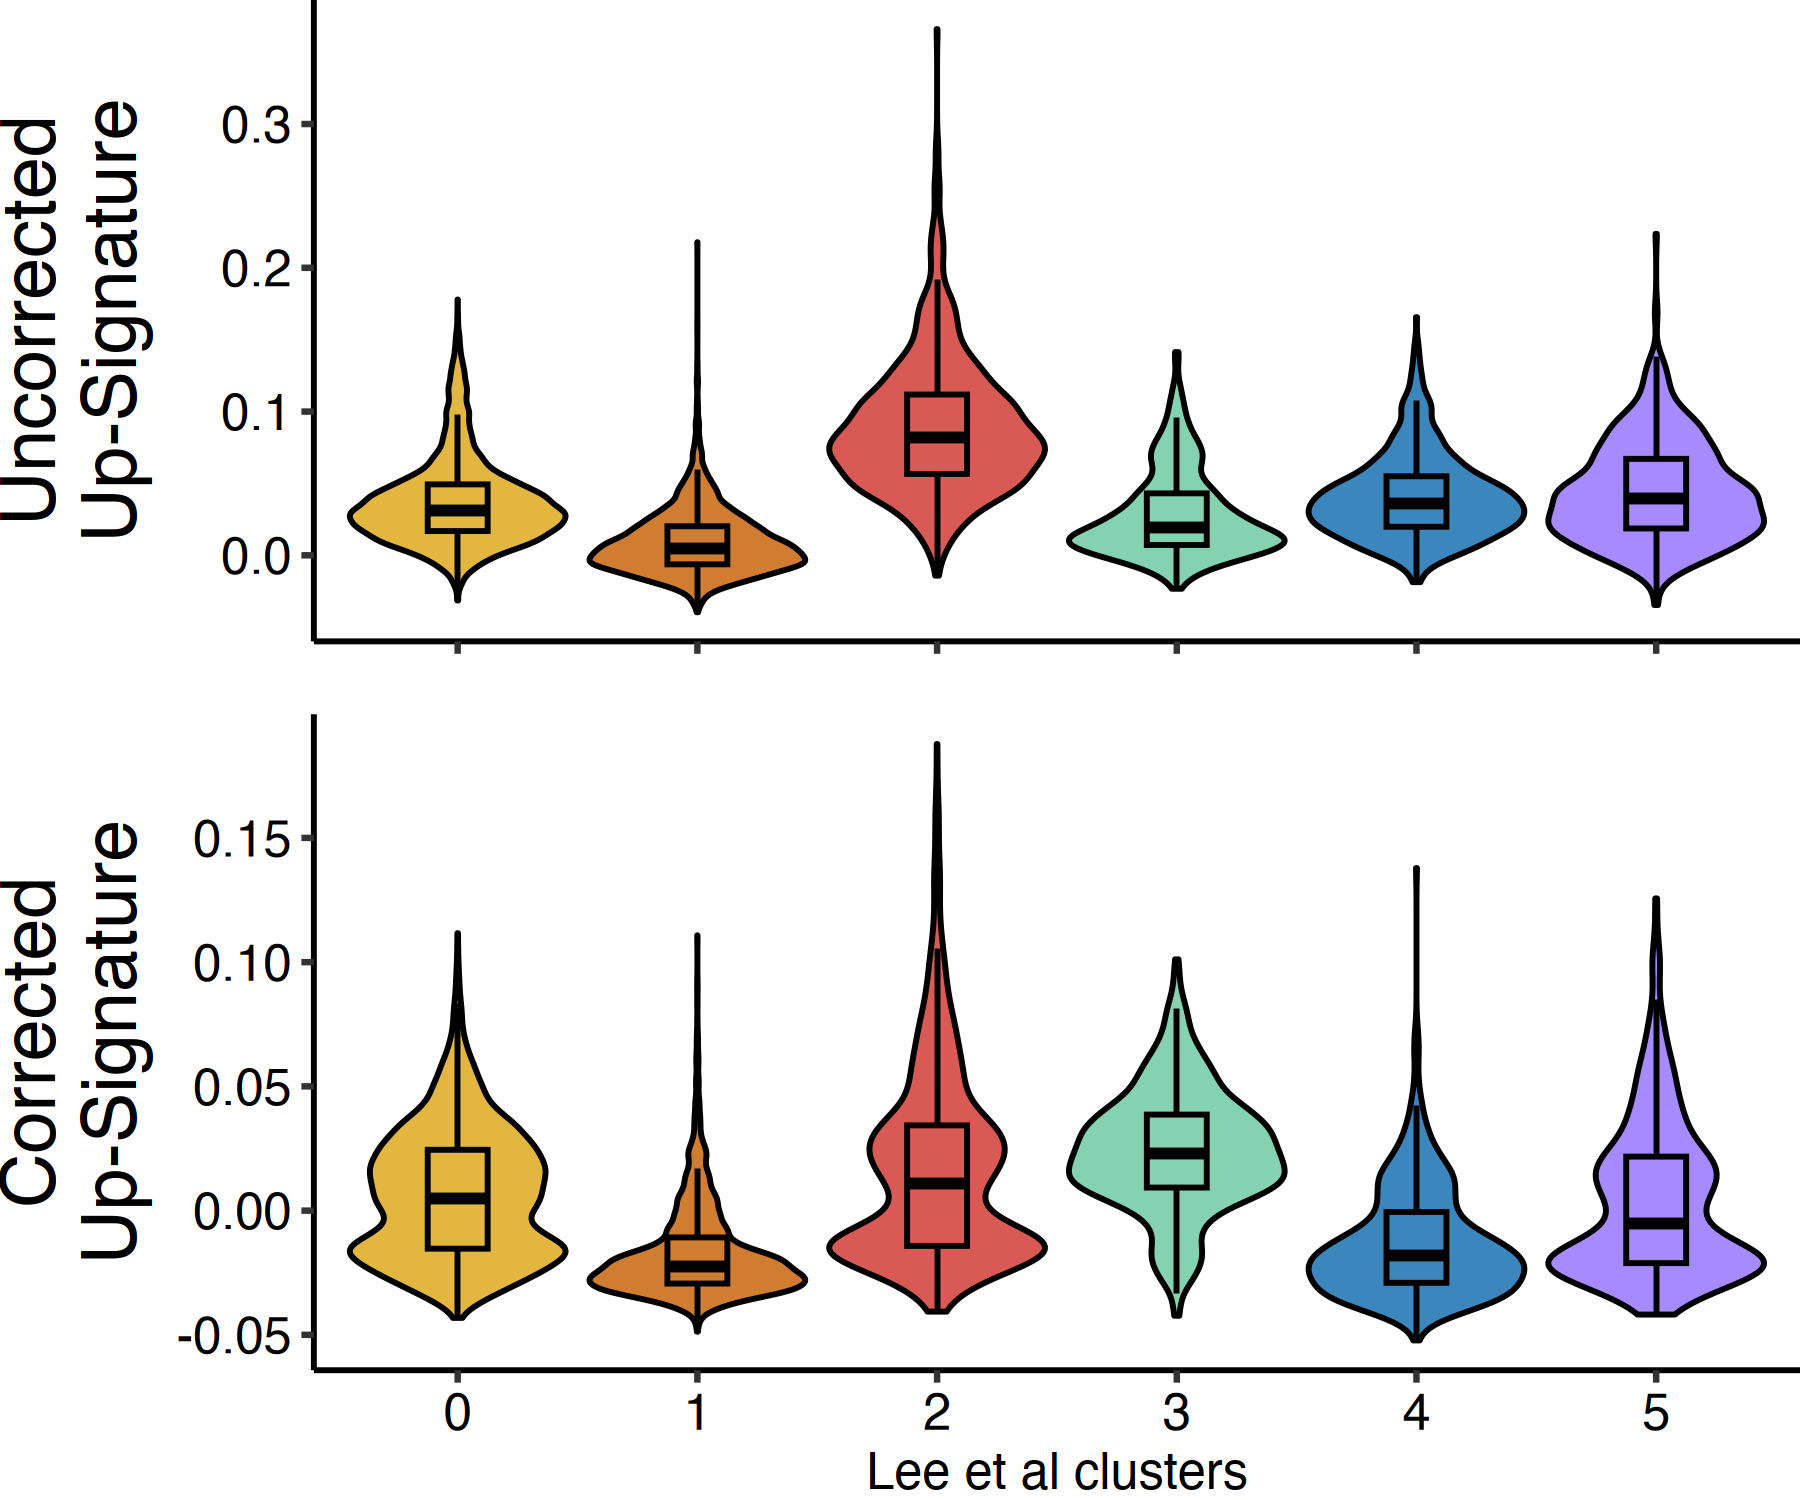

In [19]:
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res = 300)

p1 = ggplot(score_df, aes(x = seurat_clusters, y = original_upsig)) + 
    geom_violin(aes(fill = seurat_clusters), color = 'black', 
                scale = 'width', adjust = 1) + 
    geom_boxplot(aes(fill = seurat_clusters), color = 'black', outlier.shape = NA, width = 0.25) + 
        scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + theme_pubr() + NoLegend() + 
    labs(x = '', y = 'Uncorrected\nUp-Signature', title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))  

p2 = ggplot(score_df, aes(x = seurat_clusters, y = corrected_upsig)) + 
    geom_violin(aes(fill = seurat_clusters), color = 'black', 
                scale = 'width', adjust = 1) + 
    geom_boxplot(aes(fill = seurat_clusters), color = 'black', outlier.shape = NA, width = 0.25) + 
        scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    labs(x = 'Lee et al clusters', y = 'Corrected\nUp-Signature', title = NULL) + theme_pubr() + NoLegend() + 
    theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

image = plot_grid(p1, NULL, p2, ncol = 1, align = 'v', rel_heights = c(1, 0, 1.1))

ggsave(file="outputs/figures/human_corrected_vs_uncorrected_upsignature_scores_across_clusters.svg", plot=image, width=6, height=5)

image

The corrected up-signature does not appear particularly enriched in Cluster 2. We can compare this with a Wilcoxon rank-sum test:

In [20]:
signature2_results <- data.frame('comparison' = c(), 'stat' = c(), 'estimate' = c(), 'conf_lower' = c(), 'conf_upper' = c(), 'pval' = c())

for(i in c('0', '1', '3', '4', '5')){
    wilx_res =  wilcox.test(human[,WhichCells(human, idents = '2')]$SIGNATURE2, 
            human[,WhichCells(human, idents = i)]$SIGNATURE2, 
            conf.int = TRUE, 
            exact = FALSE)  

    tmp = data.frame('comparison' = paste0('Cluster 2 vs ', i), 'stat' = wilx_res$statistic, 
                     'estimate' = wilx_res$estimate, 'conf_lower' = wilx_res$conf.int[1], 'conf_upper' = wilx_res$conf.int[2], 
                     'pval' = wilx_res$p.value)

    signature2_results <- rbind(signature2_results, tmp)
}

signature2_results$pval_adj <- p.adjust(signature2_results$pval, method = 'bonferroni')

write.table(signature2_results, 
            'outputs/human_corrected_upsignature_enrichment_wilcoxon_test.csv', sep = ',', 
            quote = FALSE, row.names = FALSE, col.names = TRUE)

signature2_results

comparison     stat    estimate     conf_lower   conf_upper   pval         
W  Cluster 2 vs 0 3624750  0.005487743  0.003669160  0.007332875  2.470623e-09
W1 Cluster 2 vs 1 4913481  0.025900075  0.023526611  0.028589406 1.345180e-224
W2 Cluster 2 vs 3  332155 -0.013281502 -0.016327503 -0.010046100  4.407297e-16
W3 Cluster 2 vs 4  628577  0.022922458  0.020423181  0.025650744  5.254292e-83
W4 Cluster 2 vs 5  375613  0.009569339  0.007286247  0.012076068  5.219032e-15
   pval_adj     
W   1.235311e-08
W1 6.725899e-224
W2  2.203649e-15
W3  2.627146e-82
W4  2.609516e-14

It appears that Cluster 2 actually has lower enrichment of the corrected up-signature than Cluster 3. This further leads us to suspect Lee et al did not use the corrected up-signature when evaluating enrichment across the combined human dataset.

Let's examine expression of the corrected up-signature genes in a dot plot to emphasize the proportion of cells in each cluster expressing each gene: 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


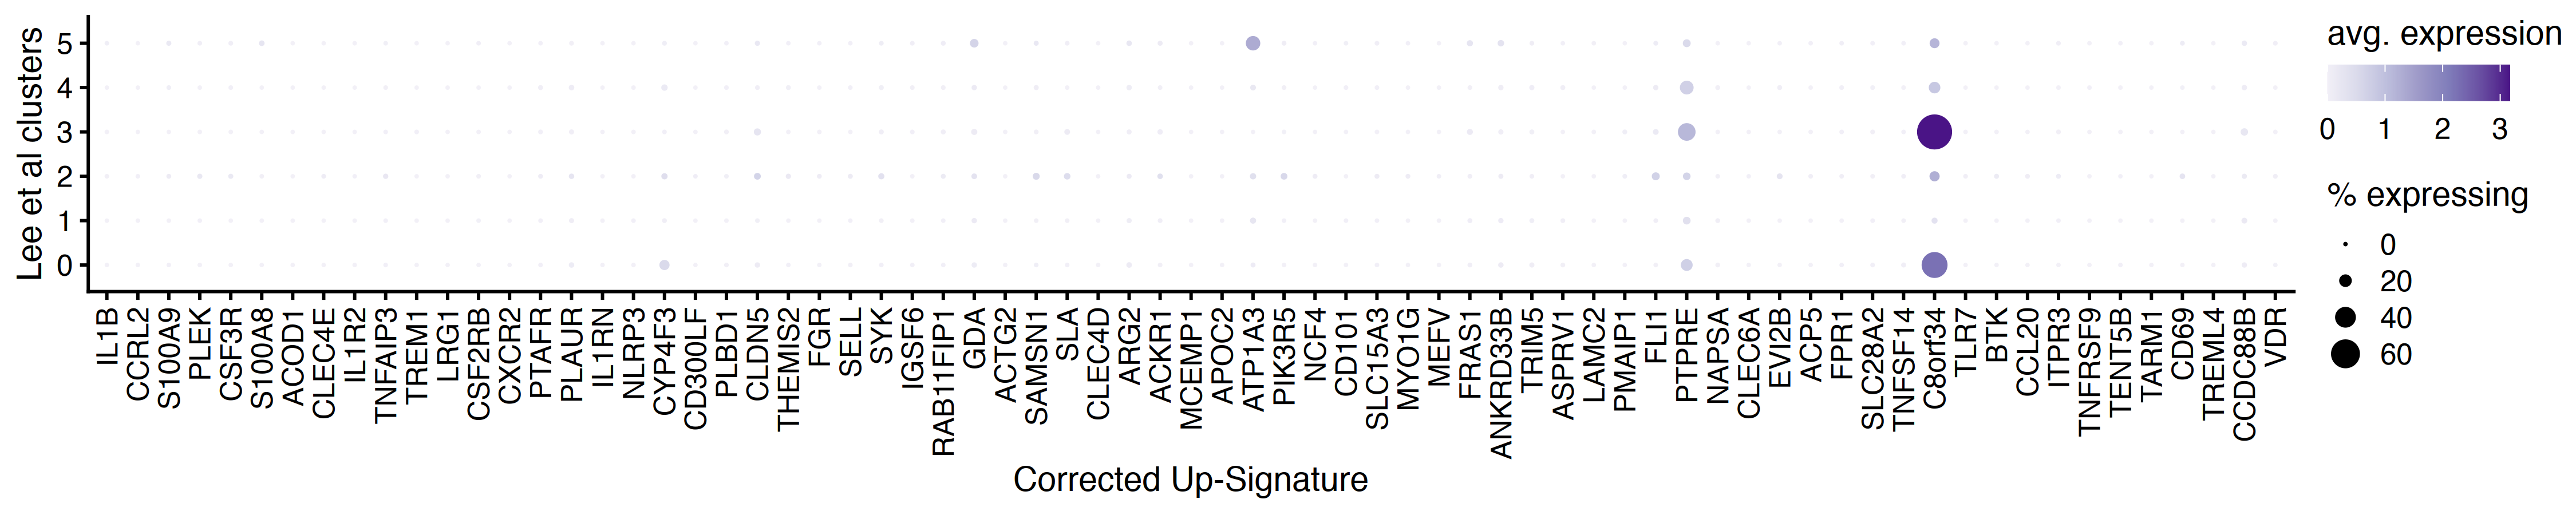

In [21]:
options(repr.plot.width=15, repr.plot.height=3, repr.plot.res = 300, warn = -1)

image = DotPlot(human, features = human_corrected_up_signature, assay = 'RNA', group.by = 'seurat_clusters', scale = FALSE, scale.min = 0, scale.max = 75) + 
    scale_color_distiller(palette = 'Purples', direction = 1, breaks = scales::pretty_breaks(n = 4)) + 
    guides(color = guide_colorbar(title = 'avg. expression', direction = "horizontal", title.position = "top"),
          size = guide_legend(title = "% expressing")) + 
    labs(y = 'Lee et al clusters', x = 'Corrected Up-Signature', color = NULL, size = '% expressing') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, face = 'italic'), legend.justification = "top")

ggsave(file="outputs/figures/extendeddatafigure2a.svg", plot=image, width=15, height=3, dpi = 600)

image

options(warn = 0)

We can see very very few cells in Cluster 2, the labeled epigenetic memory astrocytes, express any genes from the corrected up-signature. 

Scores generated from the authors' original capitalization-based gene conversion look a bit higher for Cluster 2 compared to the other clusters, appearing higher than Cluster 3: 

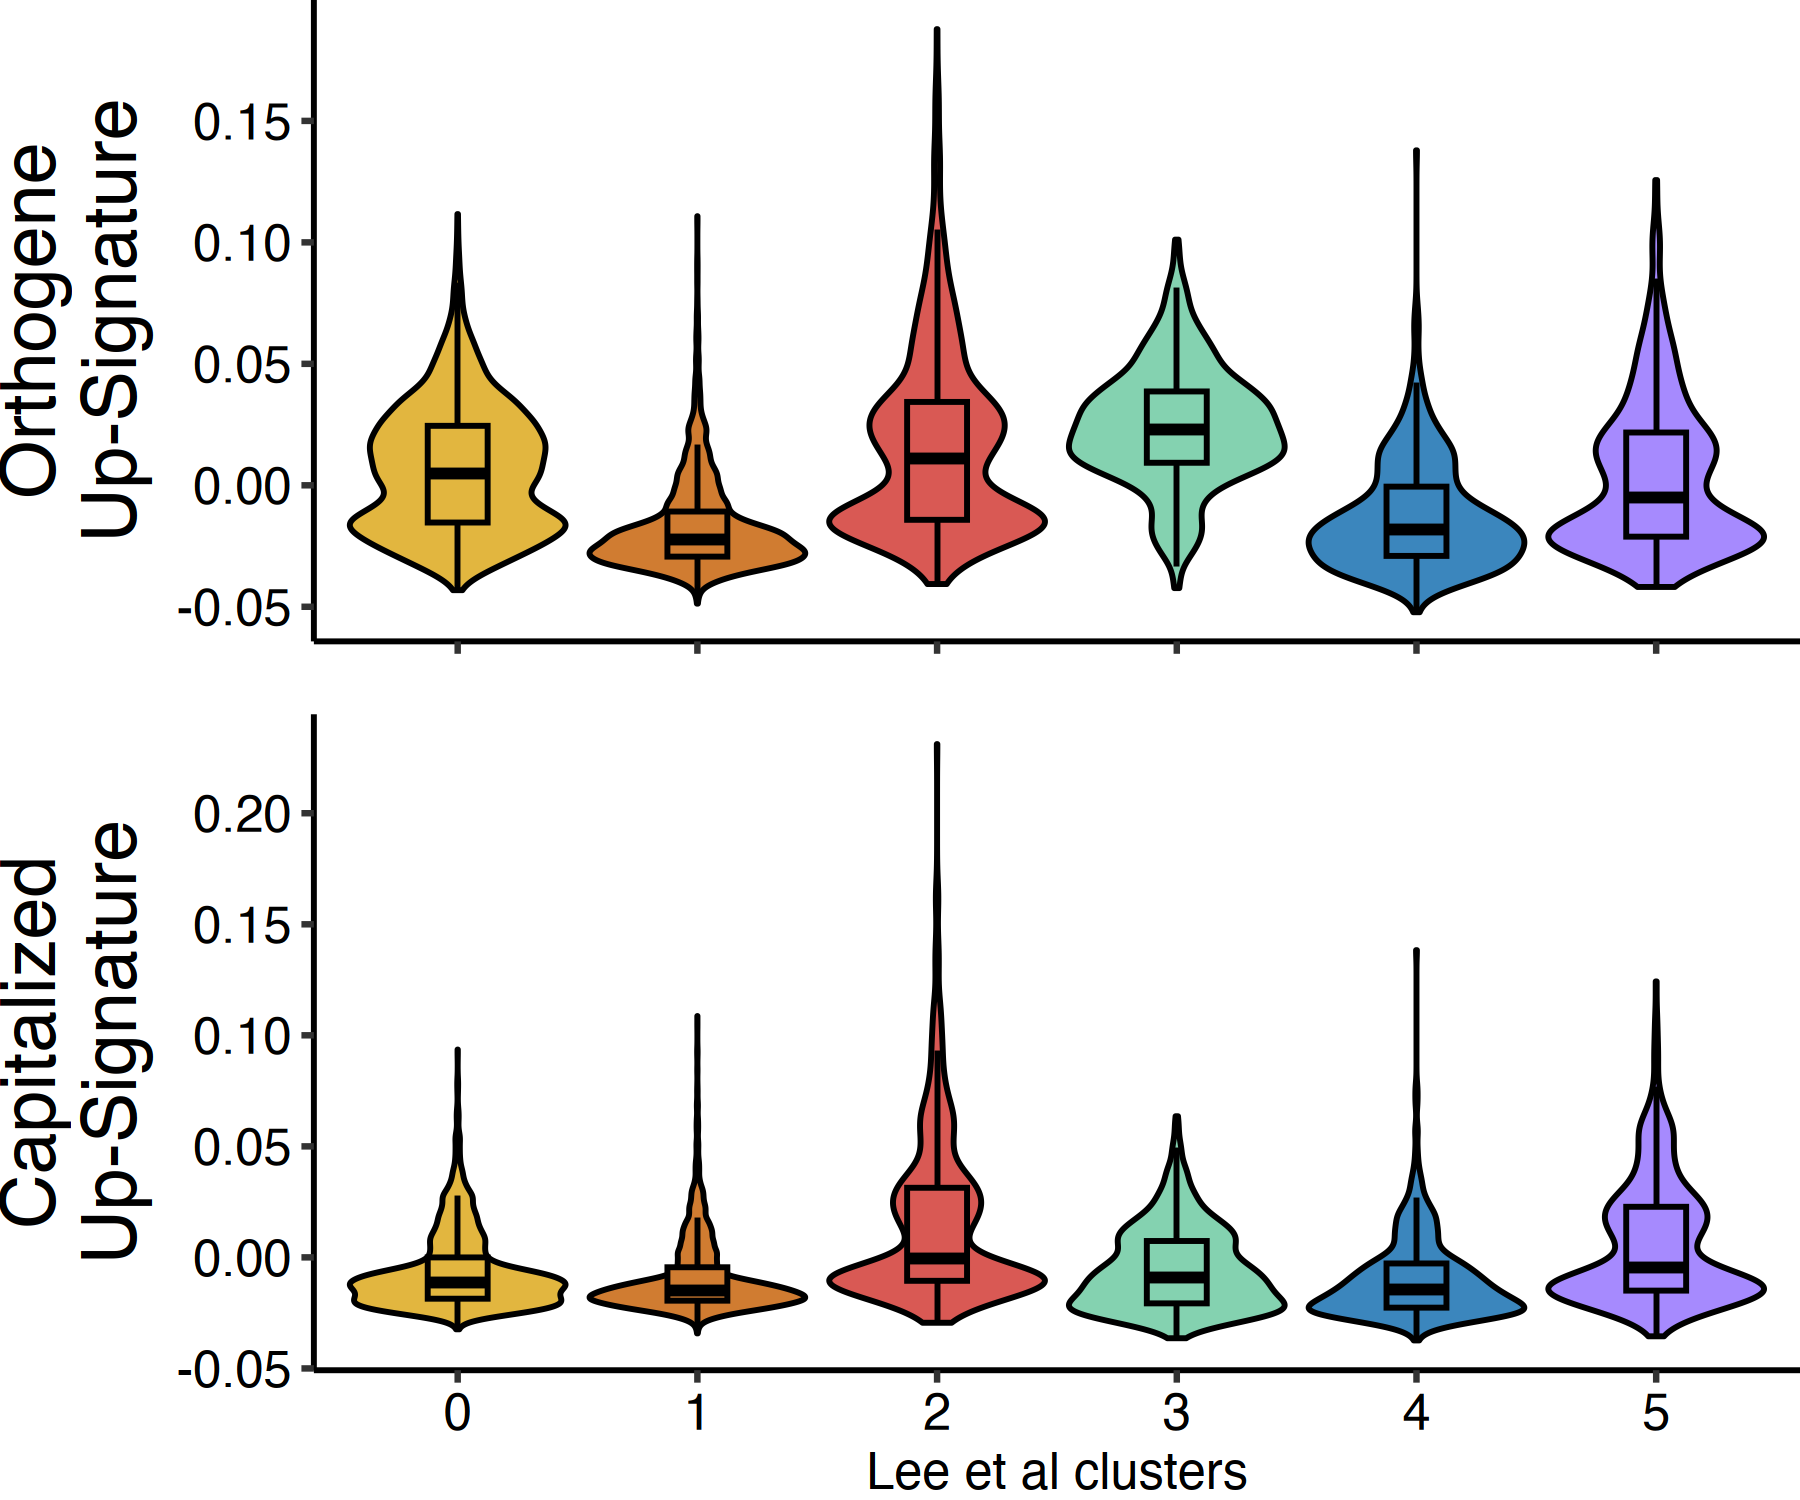

In [22]:
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res = 300)

p1 = ggplot(score_df, aes(x = seurat_clusters, y = corrected_upsig)) + 
    geom_violin(aes(fill = seurat_clusters), color = 'black', 
                scale = 'width', adjust = 1) + 
    geom_boxplot(aes(fill = seurat_clusters), color = 'black', outlier.shape = NA, width = 0.25) + 
        scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + theme_pubr() + NoLegend() + 
    labs(x = '', y = 'Orthogene\nUp-Signature', title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))  

p2 = ggplot(score_df, aes(x = seurat_clusters, y = cap_corrected_upsig)) + 
    geom_violin(aes(fill = seurat_clusters), color = 'black', 
                scale = 'width', adjust = 1) + 
    geom_boxplot(aes(fill = seurat_clusters), color = 'black', outlier.shape = NA, width = 0.25) + 
        scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    labs(x = 'Lee et al clusters', y = 'Capitalized\nUp-Signature', title = NULL) + theme_pubr() + NoLegend() + 
    theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

image = plot_grid(p1, NULL, p2, ncol = 1, align = 'v', rel_heights = c(1, 0, 1.1))

ggsave(file="outputs/figures/human_corrected_caps_vs_orthogene_upsignature_scores_across_clusters.svg", plot=image, width=6, height=5)

image

Why is this? Because simply capitalizing the mouse gene names led to the exclusion of *C8orf34* from the signature, which is the human ortholog of the mouse gene *A830018L16Rik*. This was the highest expressed gene from the signature in the human dataset, with highest expression in Cluster 3 (as seen in the above dot plot). Here's the same dot plot with capitalization conversion of mouse gene names: 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


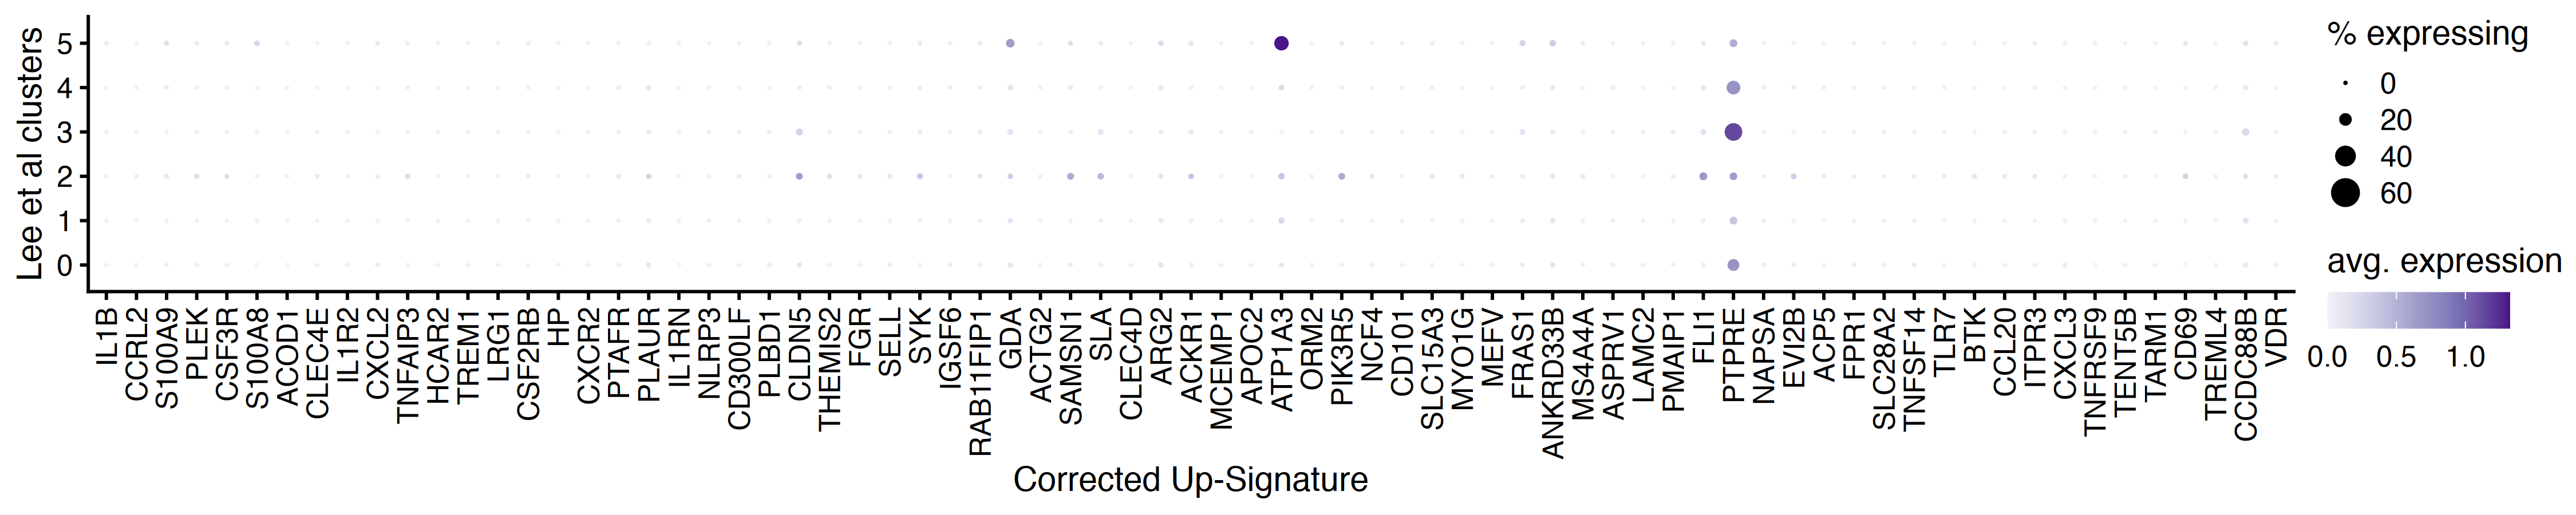

In [23]:
options(repr.plot.width=15, repr.plot.height=3, repr.plot.res = 300, warn = -1)

image = DotPlot(human, features = cap_corrected_up_signature, assay = 'RNA', group.by = 'seurat_clusters', scale = FALSE, scale.min = 0, scale.max = 75) + 
    scale_color_distiller(palette = 'Purples', direction = 1, breaks = scales::pretty_breaks(n = 4)) + 
    guides(color = guide_colorbar(title = 'avg. expression', direction = "horizontal", title.position = "top"),
          size = guide_legend(title = "% expressing")) + 
    labs(y = 'Lee et al clusters', x = 'Corrected Up-Signature', color = NULL, size = '% expressing') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, face = 'italic'), legend.justification = "top")

ggsave(file="outputs/figures/extendeddatafigure2a_capitalizationbased.svg", plot=image, width=15, height=3, dpi = 600)

image

options(warn = 0)

Regardless of the improper mouse-to-human gene conversion used in the original manuscript, there is not appreciable expression of the corrected up-signature gene set in Cluster 2, or any other cluster, in this dataset. Simply plotting dot plots of scaled gene signature scores obscures the fact that there is virtually no expression of any of the genes in this signature in this dataset.

Now we evaluate the quality control metrics and enrichment scores across the clusters defined by Lee et al.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_boxplot()`).”


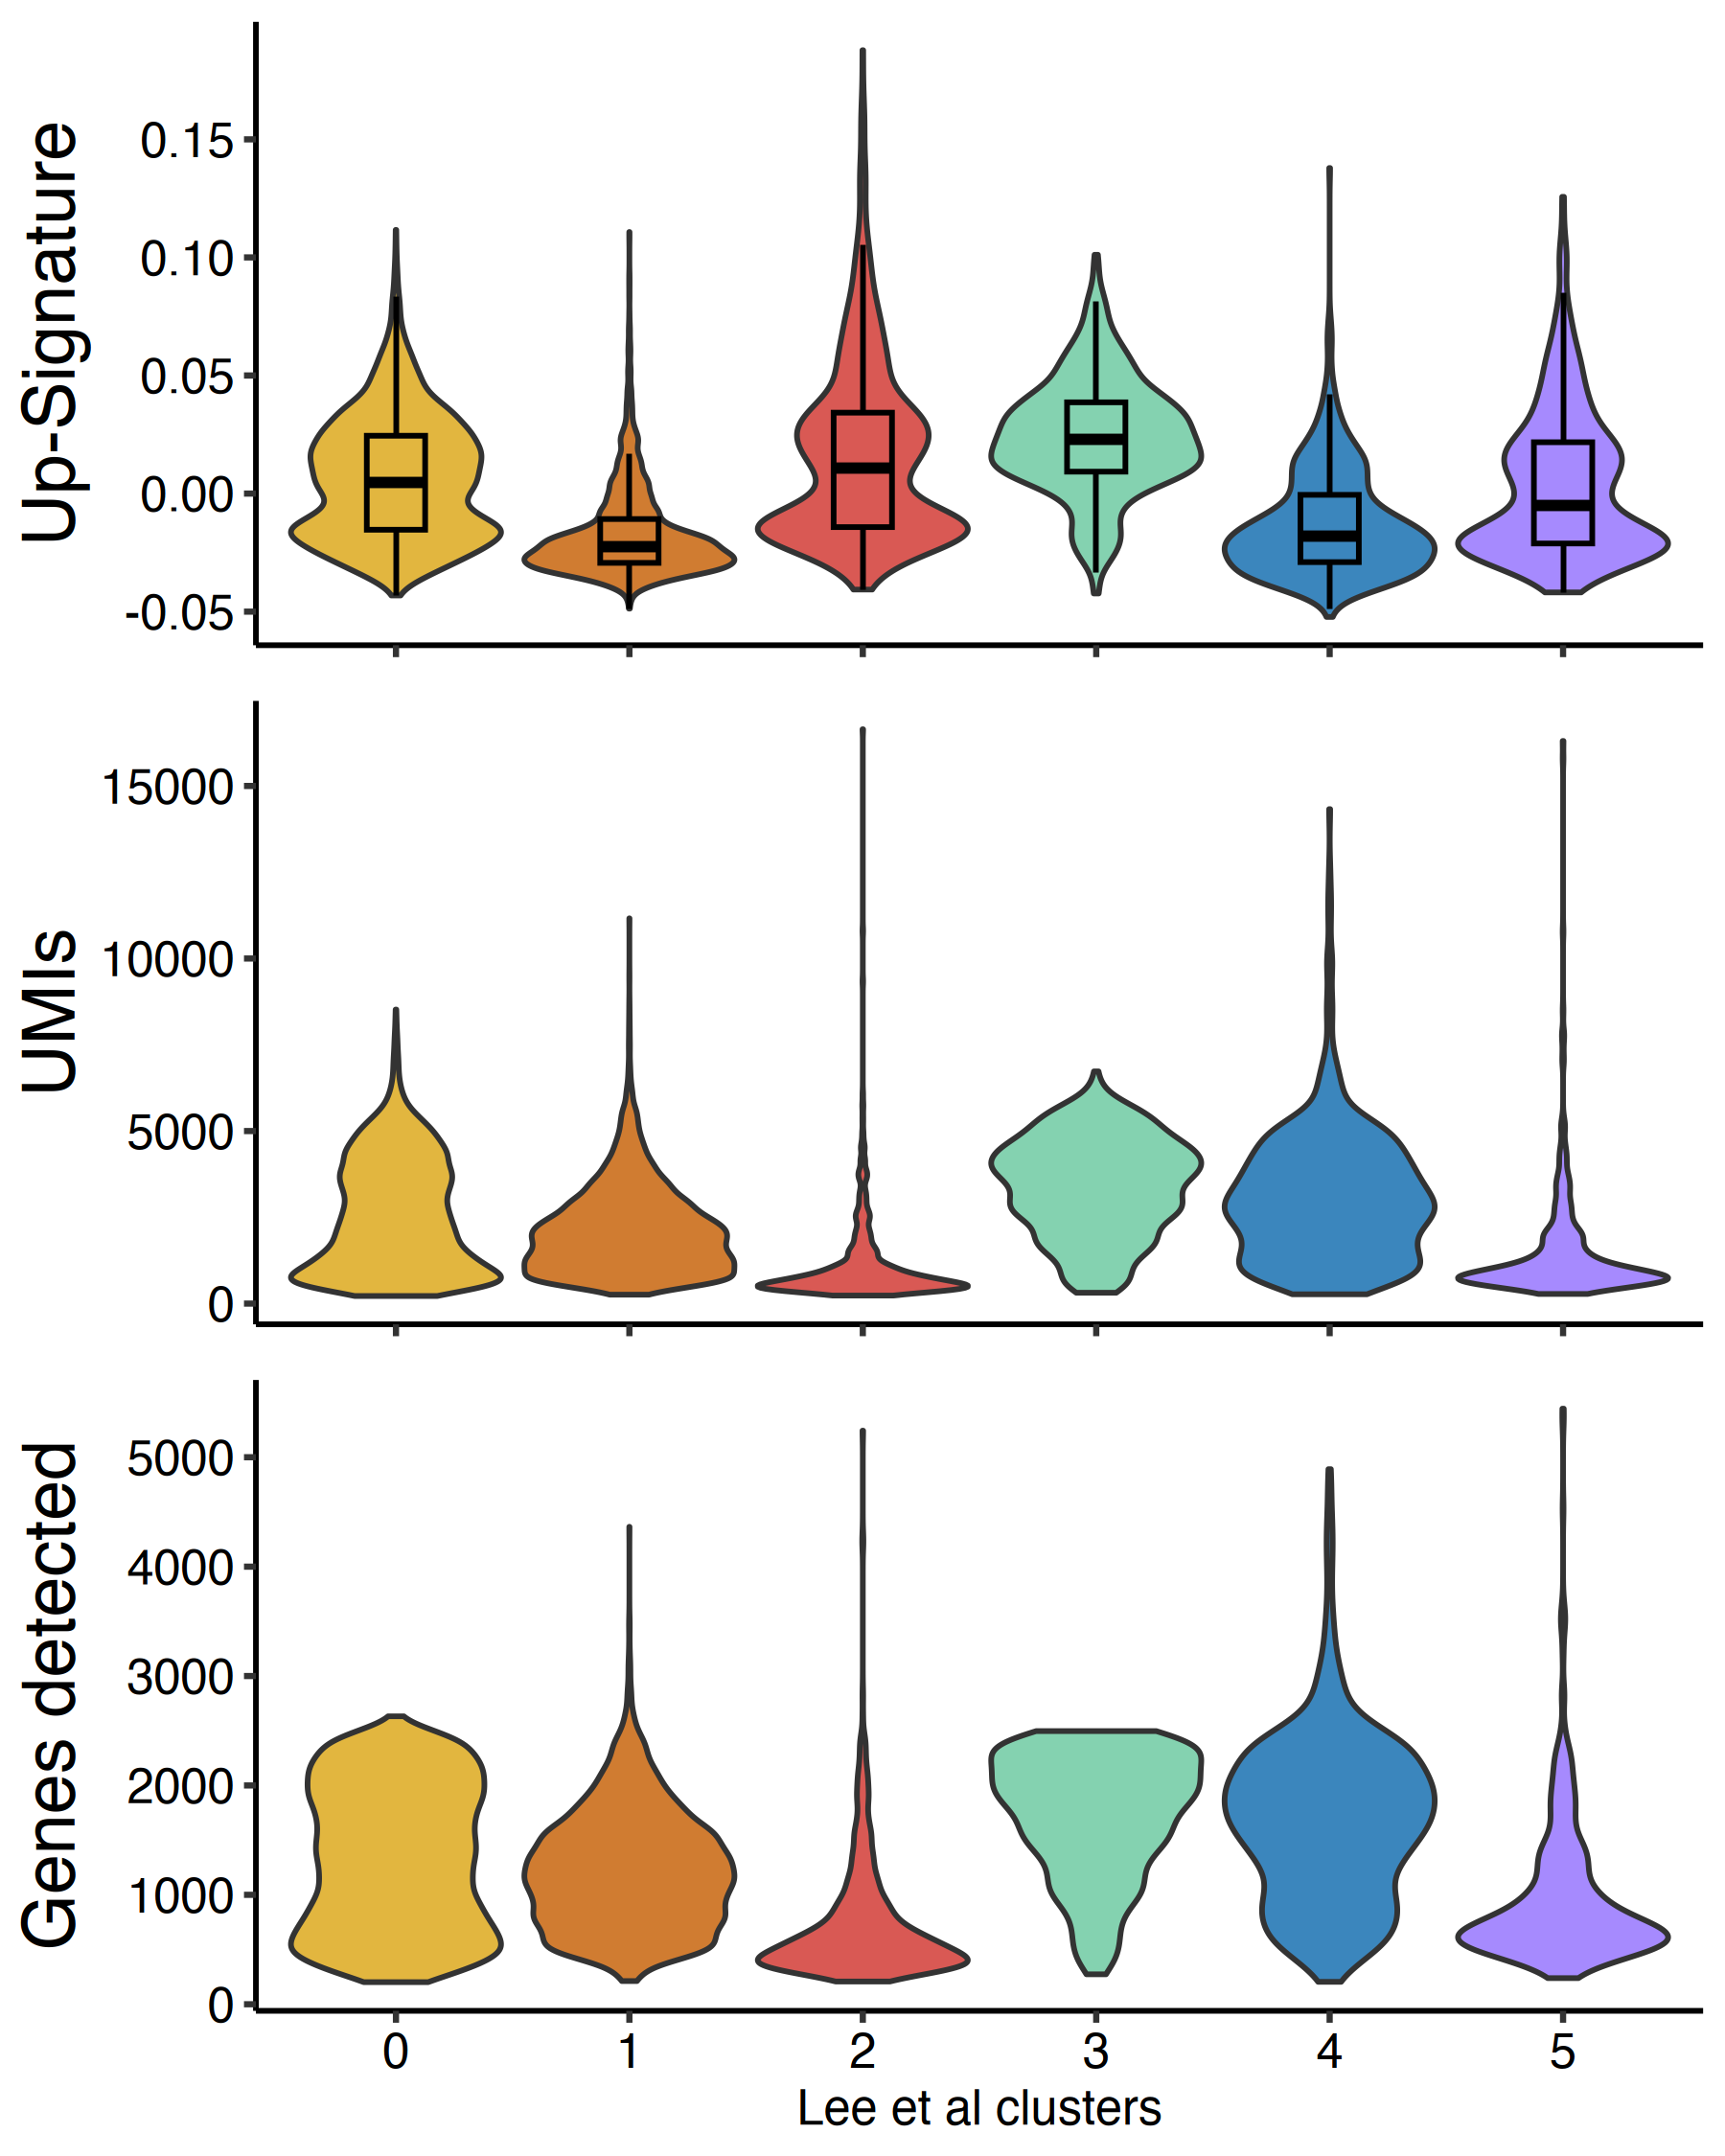

In [24]:
options(repr.plot.width=6, repr.plot.height=7.5, repr.plot.res = 300)

p1 = VlnPlot(human, features="SIGNATURE2", group.by = 'seurat_clusters', pt.size = 0)  + 
    geom_boxplot(data = score_df, aes(x = seurat_clusters, fill = seurat_clusters, y = corrected_upsig), color = 'black', outlier.shape = NA, width = 0.25) + 
        scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) + theme_pubr() + NoLegend() + 
    labs(x = NULL, y = 'Up-Signature', title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))  

p2 = VlnPlot(human, features="nCount_RNA", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = NULL, y = "UMIs", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p3 = VlnPlot(human, features="nFeature_RNA", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = 'Lee et al clusters', y = "Genes detected", title = NULL) + 
    theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

image = plot_grid(p1, NULL, p2, NULL, p3, ncol = 1, align = 'v', rel_heights = c(1, 0, 1, 0, 1.175))

ggsave(file="outputs/figures/figure3e_part1.svg", plot=image, width=6, height=7.5)

image

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


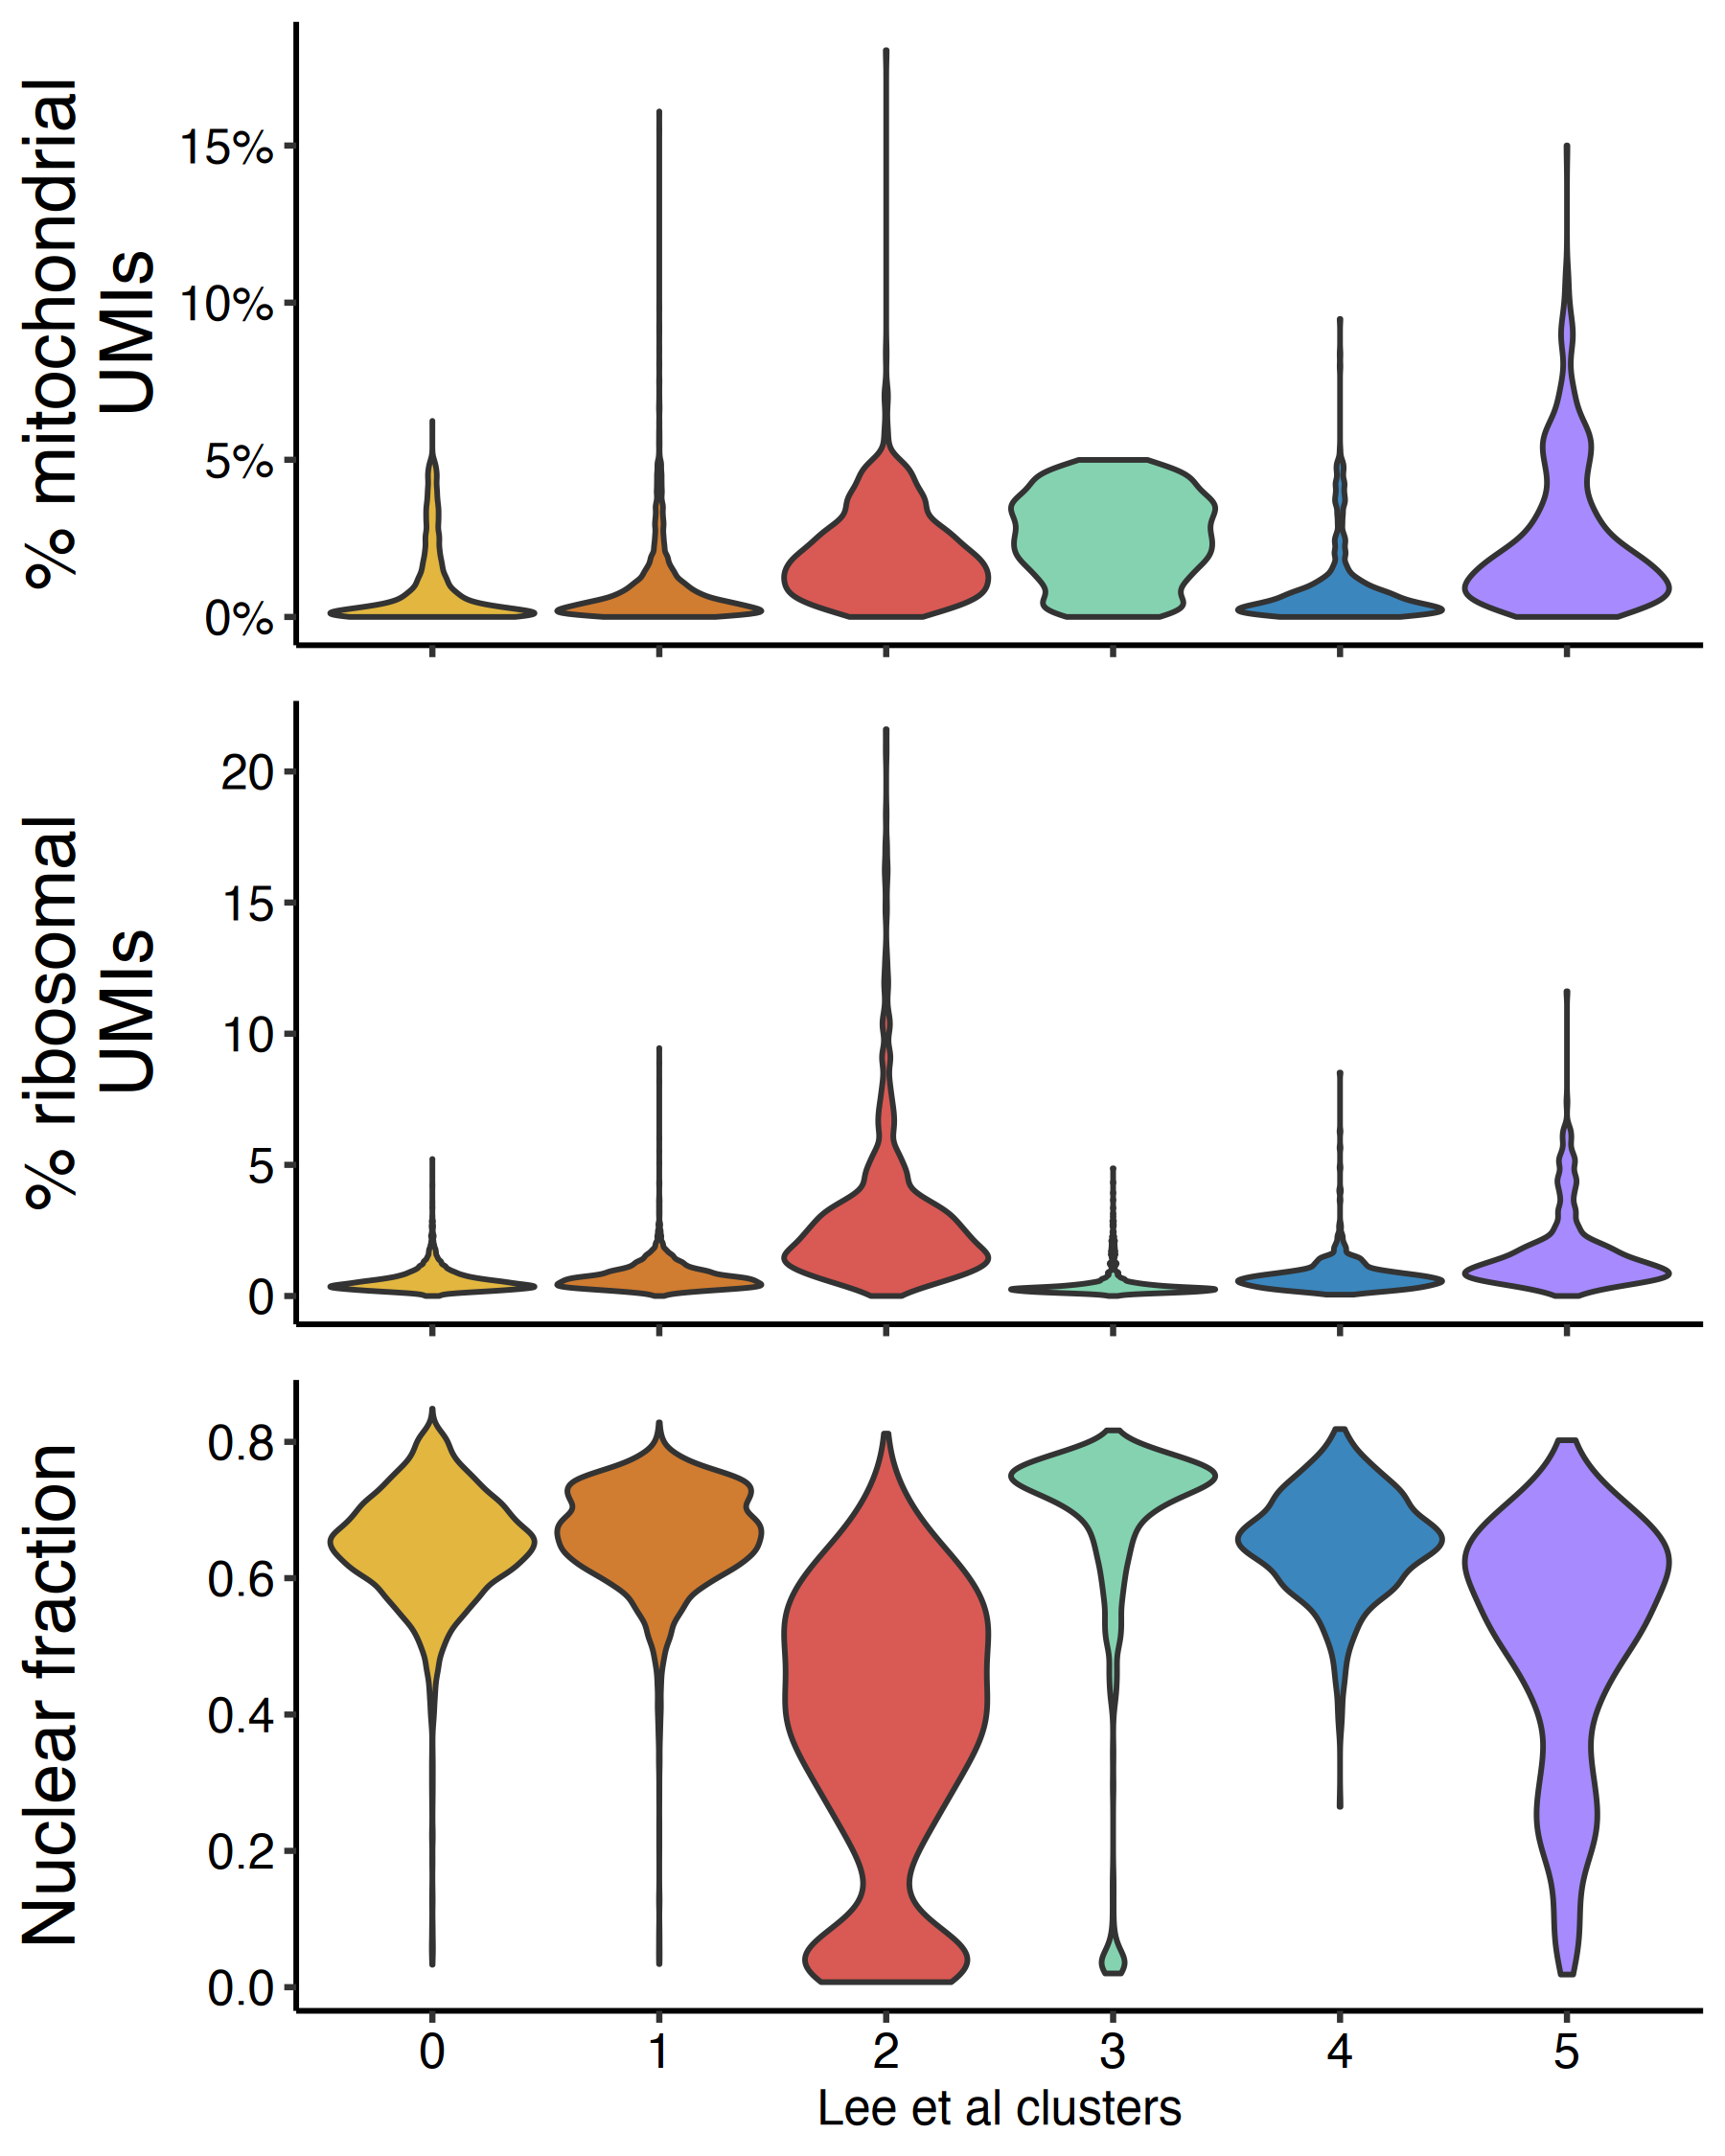

In [25]:
options(repr.plot.width=6, repr.plot.height=7.5, repr.plot.res = 300)

p1 = VlnPlot(human, features="percent.mt", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    scale_y_continuous(labels = function(x) paste0(x, '%')) + 
    labs(x = NULL, y = "% mitochondrial\nUMIs", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p2 = VlnPlot(human, features="percent.ribo", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = NULL, y = "% ribosomal\nUMIs", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p3 = VlnPlot(human, features="nuc_fraction", group.by = 'seurat_clusters', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    theme_pubr() + NoLegend() + 
    labs(x = 'Lee et al clusters', y = "Nuclear fraction", title = NULL) + 
    theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

image = plot_grid(p1, NULL, p2, NULL, p3, ncol = 1, align = 'v', rel_heights = c(1, 0, 1, 0, 1.175))

ggsave(file="outputs/figures/figure3e_part2.svg", plot=image, width=6, height=7.5)

image

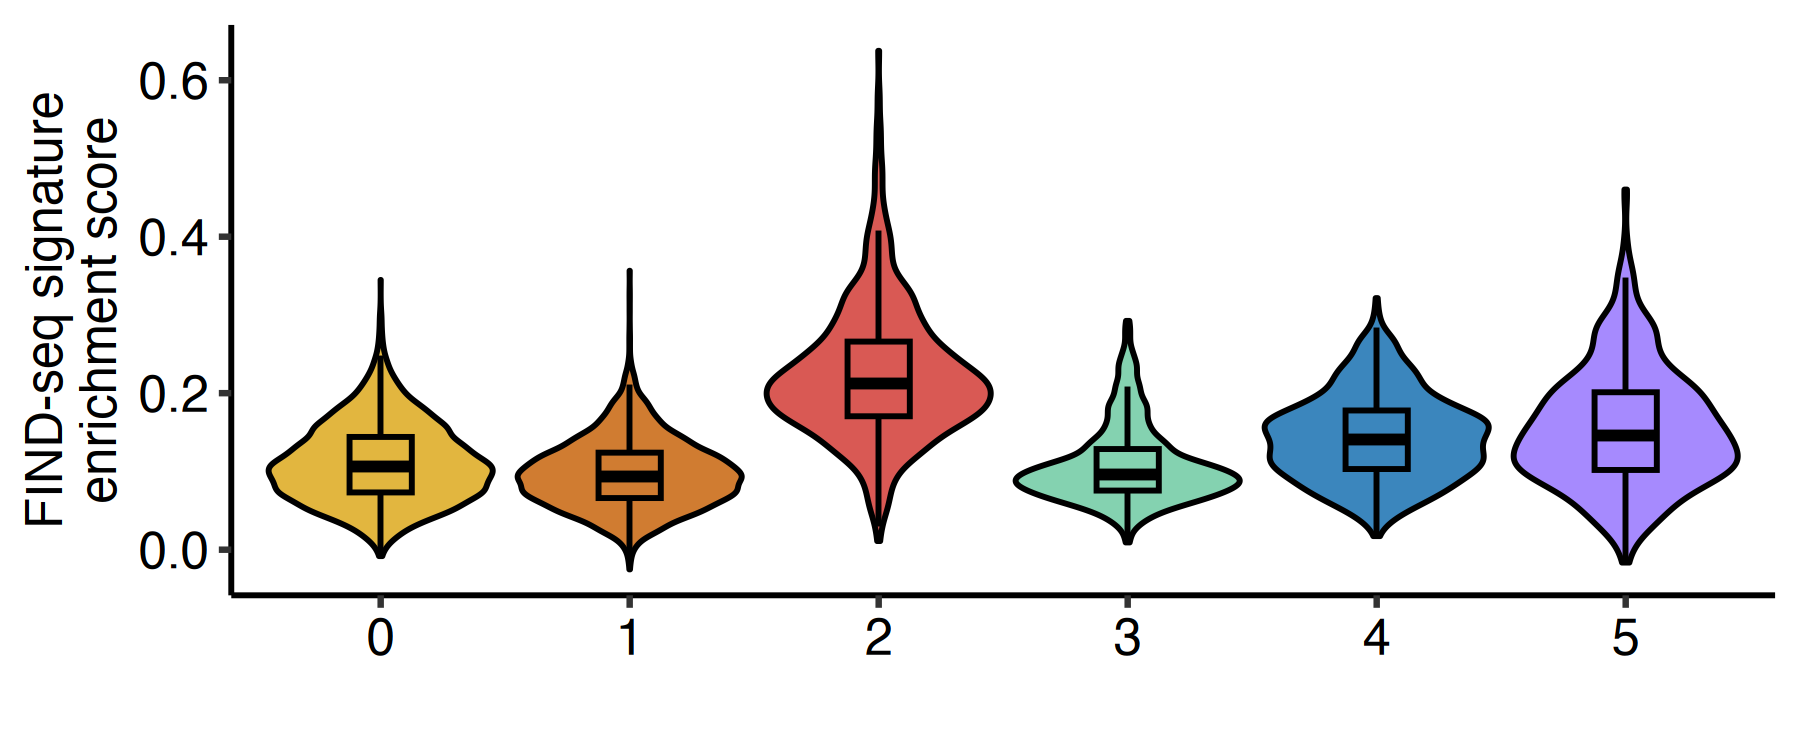

In [26]:
options(repr.plot.width=6, repr.plot.height=2.5, repr.plot.res = 300)

image = ggplot(score_df, aes(x = seurat_clusters, y = findseq)) + 
    geom_violin(aes(fill = seurat_clusters), color = 'black', 
                scale = 'width', adjust = 1) + 
    geom_boxplot(aes(fill = seurat_clusters), color = 'black', outlier.shape = NA, width = 0.25) + 
    scale_fill_manual(values = c("#e2b63f", "#d07c31", "#d95954", "#84d2b0",
                                 "#3b86bd", 
                                  "#a68afe"
                                 )) +
    labs(x = '', y = 'FIND-seq signature\nenrichment score', title = NULL) + theme_pubr() + NoLegend() + 
    theme(plot.title = element_text(face = 'bold', size = 14, hjust=0.5))

ggsave(file="outputs/figures/figure3d.svg", plot=image, width=6, height=2)

image

Now we'll examine what marker genes define each cluster. For this, we'll use the `wilcoxauc` function from the `presto` package to run a fast implementation of the Wilcoxon rank-sum test. Based on [recent work (Moses et al 2023, PMID: 37645732)](https://www.biorxiv.org/content/10.1101/2023.07.20.549945v2) comparing the formulas used to calculate log2-fold changes between Seurat, Scanpy, and other packages, we chose to use the formula from the Scanpy package instead of the one from Seurat.

In [27]:
# geometric mean with static pseudocount (Scanpy log2FC formula)
mean.fxn_geo <- function(x) {
    return(log(x = (expm1(rowMeans(x = x)) + 1e-9), base = 2))
}

# create an empty list for comparing FoldChange calculation results across all clusters
presto_results <- data.frame()

for(i in levels(Idents(human))){ # loop through all clusters
    
    print(paste0("Calculating markers for cluster ", i))
    
    data <- GetAssayData(object = human[['RNA']], layer = "data")
    
    # get cell names for groupings (from differential_expression.R line 1701-1749 [https://github.com/satijalab/seurat/blob/master/R/differential_expression.R#L1701])
    IdentsToCells <- function(
      object,
      ident.1,
      ident.2,
      cellnames.use
    ) {
      #
      if (is.null(x = ident.1)) {
        stop("Please provide ident.1")
      } 
      if (length(x = as.vector(x = ident.1)) > 1 &&
          any(as.character(x = ident.1) %in% cellnames.use)) {
        bad.cells <- cellnames.use[which(x = !as.character(x = ident.1) %in% cellnames.use)]
        if (length(x = bad.cells) > 0) {
          stop(paste0("The following cell names provided to ident.1 are not present in the object: ", paste(bad.cells, collapse = ", ")))
        }
      } else {
        ident.1 <- WhichCells(object = object, idents = ident.1)
      }
      # if NULL for ident.2, use all other cells
      if (length(x = as.vector(x = ident.2)) > 1 &&
          any(as.character(x = ident.2) %in% cellnames.use)) {
        bad.cells <- cellnames.use[which(!as.character(x = ident.2) %in% cellnames.use)]
        if (length(x = bad.cells) > 0) {
          stop(paste0("The following cell names provided to ident.2 are not present in the object: ", paste(bad.cells, collapse = ", ")))
        }
      } else {
        if (is.null(x = ident.2)) {
          ident.2 <- setdiff(x = cellnames.use, y = ident.1)
        } else {
          ident.2 <- WhichCells(object = object, idents = ident.2)
        }
      }
      return(list(cells.1 = ident.1, cells.2 = ident.2))
    }
    
    # extract cell lists using IdentsToCells function
    cells <- IdentsToCells(object = human, ident.1 = i, ident.2 = NULL, cellnames.use = colnames(human))
    cells.1 <- cells$cells.1
    cells.2 <- cells$cells.2

    # order data matrix by group
    data <- data[, c(cells.1, cells.2), drop = FALSE]

    # calculate Scanpy fold change
    data.1 <- mean.fxn_geo(data[, cells.1, drop = FALSE])
    data.2 <- mean.fxn_geo(data[, cells.2, drop = FALSE])
    fc_geo <- (data.1 - data.2)

    # get group labels
    group.info <- data.frame(row.names = c(cells.1, cells.2))
    group.info[cells.1, "group"] <- "Group1"
    group.info[cells.2, "group"] <- "Group2"
    group.info[, "group"] <- factor(x = group.info[, "group"])

     # run presto wilcoxon test
    res <- wilcoxauc(X = data, y = group.info[, "group"])
    res <- res[1:(nrow(x = res)/2),]
    res$cluster <- i
    res$log2FC = fc_geo

    res$padj <- NULL
    res$logFC <- NULL
    res$group <- NULL
    
    res$p_val_adj = p.adjust(
      p =res$pval,
      method = "bonferroni",
      n = nrow(data)
    )
    
    presto_results <- rbind(presto_results, res)

}

# replace zero p-values with more accurate minimum value representable
presto_results = presto_results %>% mutate(p_val_adj = ifelse(p_val_adj == 0, .Machine$double.xmin, p_val_adj))

# save CSV file of results table
write.table(presto_results %>% arrange(cluster, p_val_adj, desc(log2FC)), 'outputs/human_clusters_de_test_results.csv', sep = ',', quote = FALSE, row.names = FALSE, col.names = TRUE)

# save CSV file with the cluster 2 significant DEGs (+-1 log2FC, padj < 0.05)
cluster2_sig_results <- presto_results %>% filter(cluster == '2') %>% filter(abs(log2FC) > 1) %>% filter(p_val_adj < 0.05) %>% arrange(p_val_adj, desc(log2FC))

print("")
print("")
print("")

print("Top Cluster 2 marker genes:")
print(head(cluster2_sig_results %>% filter(log2FC > 1)))

write.table(cluster2_sig_results, 'outputs/human_cluster2_wilcoxon_test_results_DEGs.csv', sep = ',', quote = FALSE, row.names = FALSE, col.names = TRUE)

[1] "Calculating markers for cluster 0"
[1] "Calculating markers for cluster 1"
[1] "Calculating markers for cluster 2"
[1] "Calculating markers for cluster 3"
[1] "Calculating markers for cluster 4"
[1] "Calculating markers for cluster 5"
[1] ""
[1] ""
[1] ""
[1] "Top Cluster 2 marker genes:"
   feature   avgExpr statistic       auc          pval   pct_in    pct_out
1 ARHGAP15 0.5769466   8719772 0.5907398 1.278616e-251 19.50207  1.6131139
2    SKAP1 0.3502998   8234854 0.5578879 1.937223e-226 12.03320  0.5094044
3    IGHGP 0.7043629   8643983 0.5856052 3.493535e-224 18.56846  1.6718913
4      FTL 2.5758619  11508674 0.7796799 4.628288e-224 73.34025 43.2144723
5    PTPRC 0.5574559   8662714 0.5868742 5.665299e-222 18.87967  1.7698537
6      B2M 1.5238714  10400726 0.7046196 1.709150e-219 50.82988 16.3009404
  cluster   log2FC     p_val_adj
1       2 4.876772 7.926395e-247
2       2 5.761931 1.200924e-221
3       2 4.832649 2.165712e-219
4       2 3.057616 2.869168e-219
5       2 4.605

We note that some of the top marker genes for each cluster include canonical marker genes for non-astrocyte cell types.

Centering and scaling data matrix

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


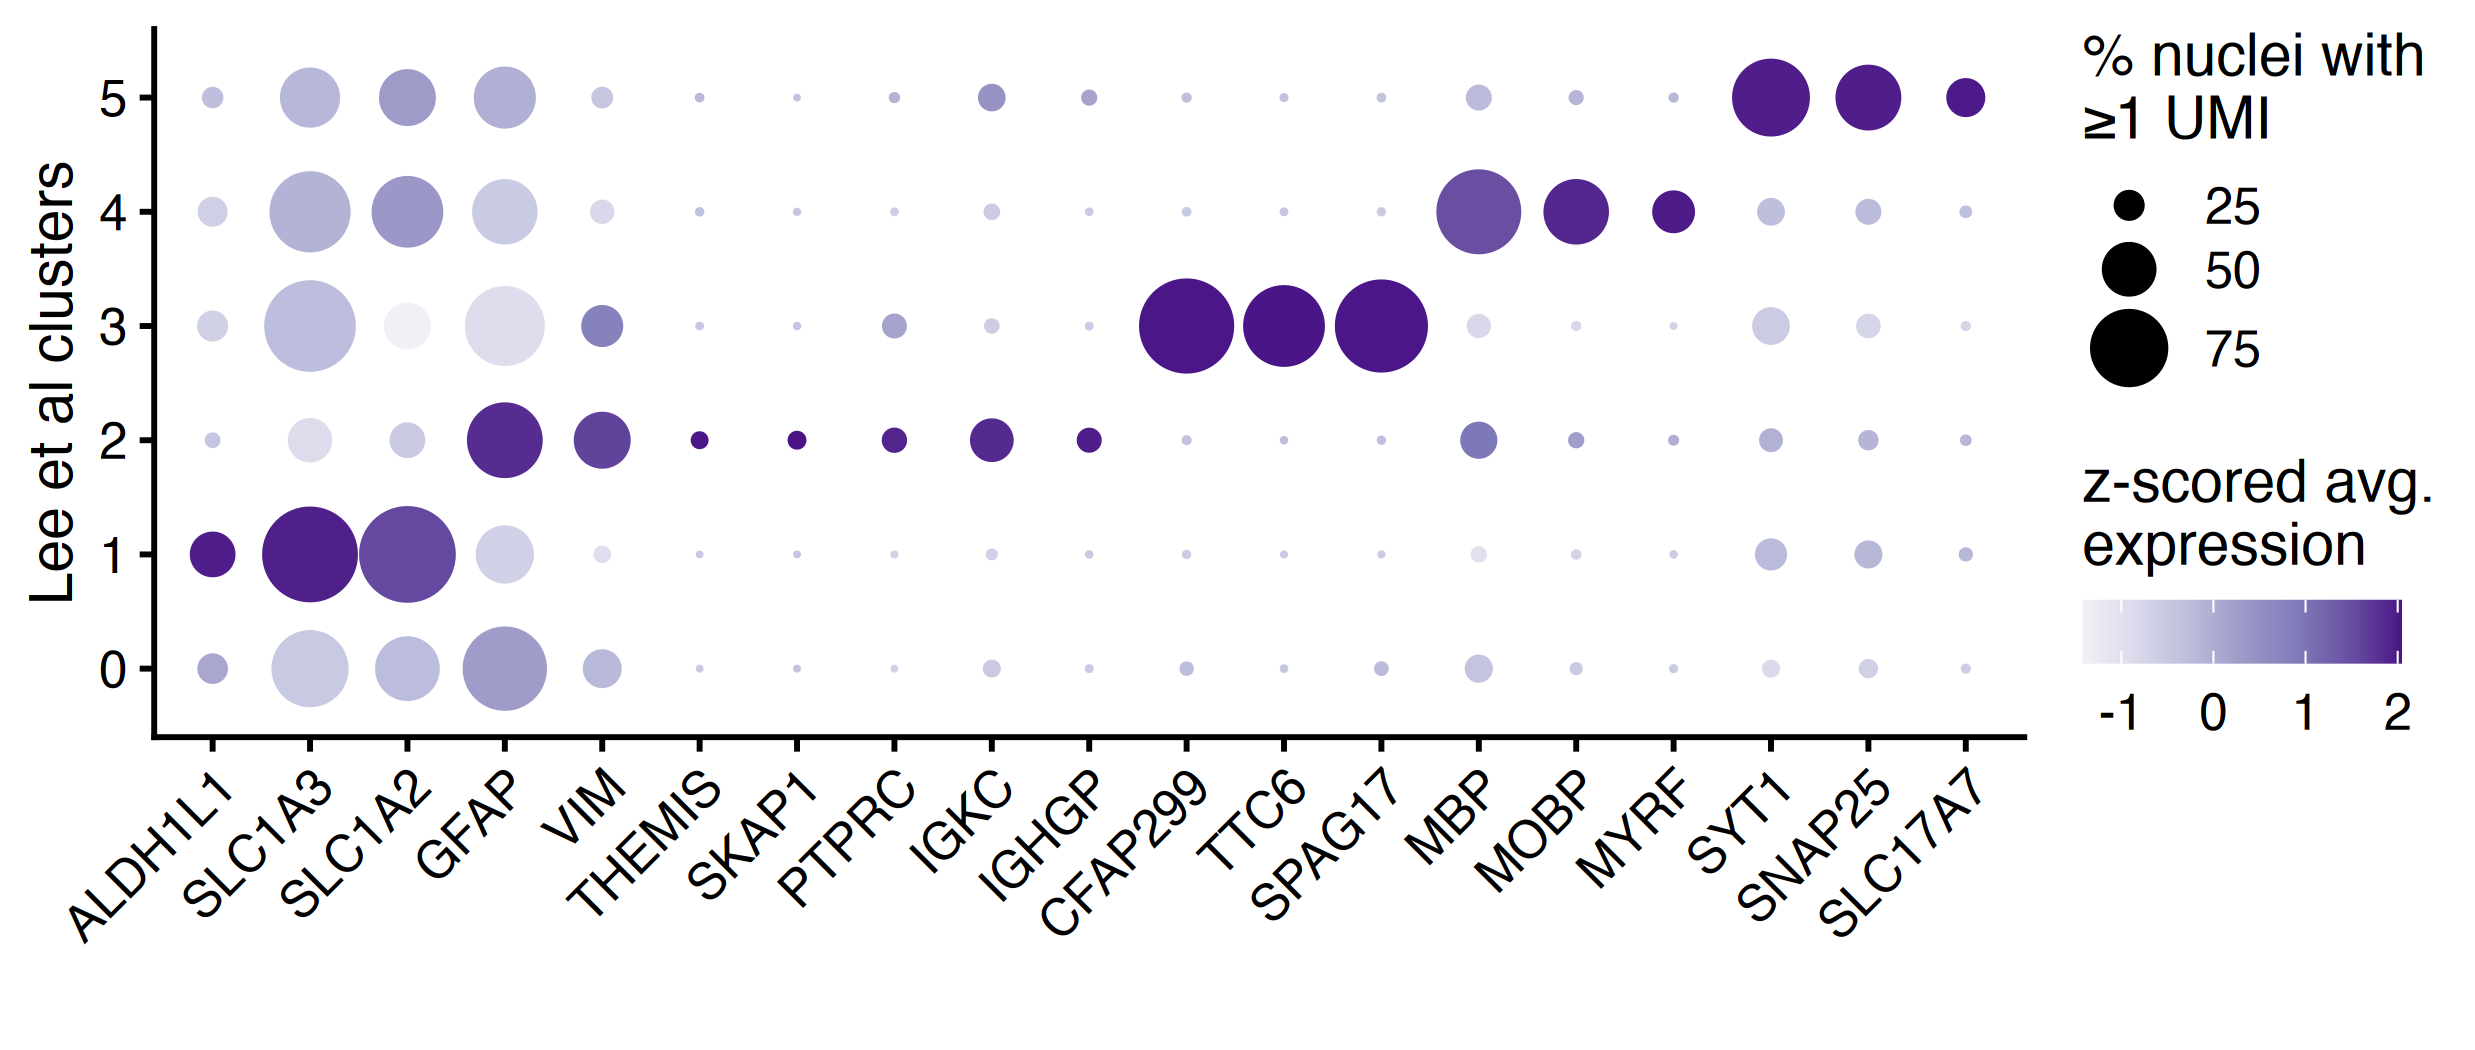

In [28]:
options(repr.plot.width=8.25, repr.plot.height=3.5, repr.plot.res = 300, warn = -1)
human <- ScaleData(human)
image = DotPlot(human, features = c('ALDH1L1', 'SLC1A3', 'SLC1A2',
                            'GFAP', 'VIM',
                            'THEMIS', 'SKAP1', 'PTPRC', 'IGKC','IGHGP', 
                            'CFAP299', 'TTC6', 'SPAG17',
                           'MBP', 'MOBP', 'MYRF',
                            'SYT1', 'SNAP25', 'SLC17A7'
                           ), scale = TRUE,
       dot.scale = 10, group.by = 'seurat_clusters') + 
    labs(x = "", y = "Lee et al clusters", color = "avg. z-score\nexpression") + scale_color_distiller(palette = 'Purples', direction = 1) + 
    scale_y_discrete() + 
    guides(color = guide_colorbar(title = 'z-scored avg.\nexpression', direction = "horizontal", title.position = "top"),
          size = guide_legend(title = "% nuclei with\n≥1 UMI")) + 
    theme(axis.text.x = element_text(angle = 45, hjust=1,face = 'italic'))

ggsave(file="outputs/figures/figure3b.svg", plot=image, width=8.25, height=3.5, dpi = 600)

image

options(warn = 0)

Warning message:
“Removed 61958 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


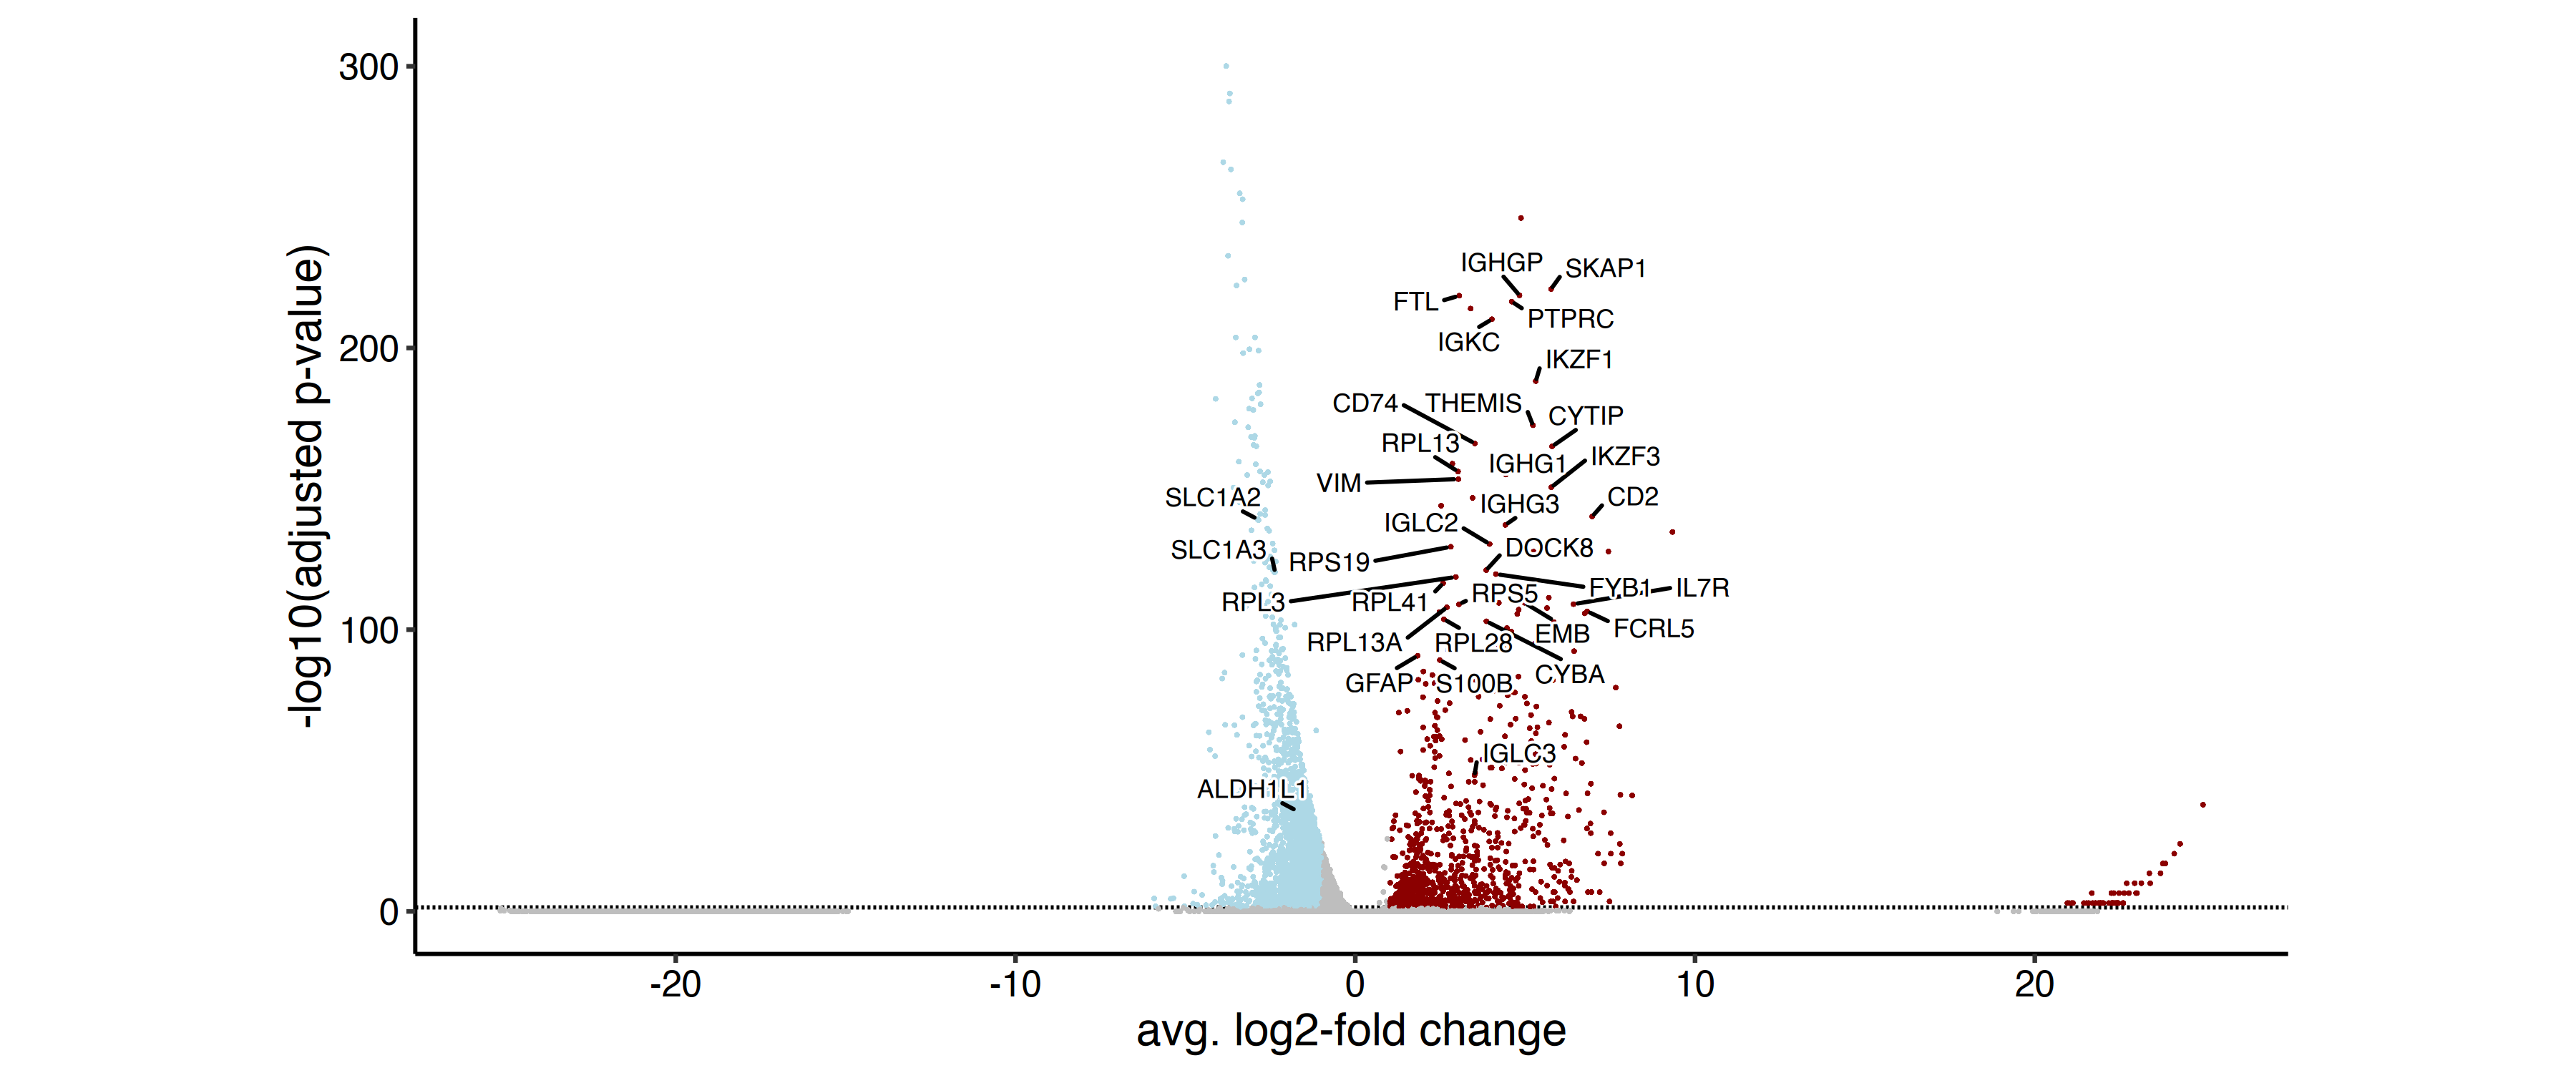

In [29]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 300)

highlight_genes <- c('VIM', 'GFAP', 'FTL',
                    'IGHGP', 'IGKC', 'IGHG1', 'IGHG3', 'IGLC3', 'IGLC2',
                     'CD74', 'CYBA', 'CYTIP', 'FCRL5',
                     'EMB', 'CD2', 'IL7R', 'IKZF3', 'IKZF1', 'THEMIS', 'PTPRC', 'SKAP1', 'FYB1', 'DOCK8',
                     'RPL13', 'RPL41', 'RPL28', 'RPS19', 'RPL13A', 'RPL3', 'RPS5',
                     'SLC1A3', 'SLC1A2', 'ALDH1L1', 'S100B'
                    )

ggplot(data = presto_results %>% filter(cluster == "2") %>% mutate(label = ifelse(feature %in% highlight_genes, feature, NA)) %>% 
                                                                         mutate(significance = ifelse((p_val_adj < 0.05) & (log2FC > 1), "Up", 
                                                                                              ifelse((p_val_adj < 0.05) & (log2FC < -1), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FC, y = -log10(p_val_adj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.1), dpi = 1200) + 
    labs(x = "avg. log2-fold change", y = "-log10(adjusted p-value)") + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 2, min.segment.length = 0, 
                     fontface = 'italic',
                    bg.color = "white",
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size=15),
      aspect.ratio = 0.5
            )

Warning message:
“Removed 15124 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 61968 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 15124 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 61968 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


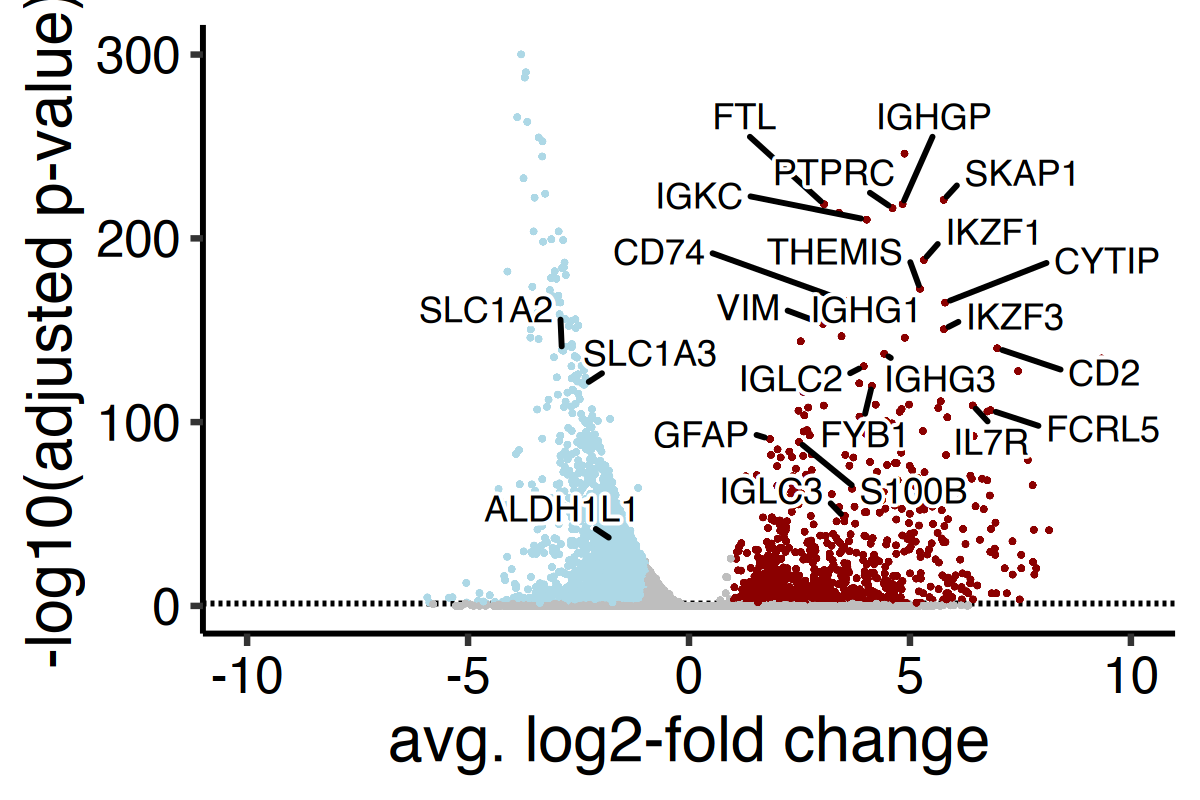

In [30]:
options(repr.plot.width=4, repr.plot.height=2.666, repr.plot.res = 300)

highlight_genes <- c('VIM', 'GFAP', 'FTL',
                    'IGHGP', 'IGKC', 'IGHG1', 'IGHG3', 'IGLC3', 'IGLC2',
                     'CD74', 'CYTIP', 'FCRL5',
                     'CD2', 'IL7R', 'IKZF3', 'IKZF1', 'THEMIS', 'PTPRC', 'SKAP1', 'FYB1',
                     'SLC1A3', 'SLC1A2', 'ALDH1L1', 'S100B'
                    )

image = ggplot(data = presto_results %>% filter(cluster == "2") %>% mutate(label = ifelse(feature %in% highlight_genes, feature, NA)) %>% 
                                                                         mutate(significance = ifelse((p_val_adj < 0.05) & (log2FC > 1), "Up", 
                                                                                              ifelse((p_val_adj < 0.05) & (log2FC < -1), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FC, y = -log10(p_val_adj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.1), dpi = 1200) + 
    labs(x = "avg. log2-fold change", y = "-log10(adjusted p-value)") + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 1, min.segment.length = 0, 
                     fontface = 'italic',
                    bg.color = "white",
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    scale_x_continuous(limits = c(-10, 10)) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size=15)
            )

ggsave(file="outputs/figures/figure3c.svg", plot=image, width=4, height=2.666)

image

Because Cluster 2 is marked by higher expression of T cell and B cell marker genes as well as *GFAP* and *VIM*, we next examined whether these genes were expressed across all nuclei in this cluster or by only a subset. To do this, we plot expression of the top 50 Cluster 2 marker genes ordered by p-value across all Cluster 2 nuclei in a heatmap.

With random ordering of the nuclei in the heatmap columns, the plot would be more difficult to interpret and subgroups may not be easily identifiable. In order to group transcriptomically similar nuclei together in the plot, we cluster the nuclei based on Euclidean distance in PCA space.

In [31]:
features = (cluster2_sig_results %>% filter(log2FC > 1))[1:50,]$feature

human$sample_number <- gsub("(.*)-(.*)", "\\2",colnames(human))
memory_astrocytes <- human[,WhichCells(human, idents = '2')]
memory_astrocytes <- FindVariableFeatures(memory_astrocytes, nfeatures = 2000, selection.method = 'dispersion')
memory_astrocytes <- ScaleData(memory_astrocytes)
memory_astrocytes <- RunPCA(memory_astrocytes)
memory_astrocytes <- RunHarmony(memory_astrocytes, group.by.vars = c('sample_number', 'source'))
dend = as.dendrogram(hclust(dist(memory_astrocytes@reductions$harmony@cell.embeddings[,1:20])))

cluster2_heatmap_mat <- as.matrix(memory_astrocytes[["RNA"]]$data[features,])

Finding variable features for layer data

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”
PC_ 1 
Positive:  MT-RNR2, RPS28, PTPRC, ARHGAP15, MT-RNR1, BCYRN1, RABGAP1L, SKAP1, THEMIS, RPS27 
	   MBNL1, RUNX1, SYT1, PARP8, IFNG-AS1, FBXW7, AOAH, PRKCH, IKZF1, LINC01934 
	   TNFAIP8, CYRIB, RESF1, RPLP2, HLA-B, CAMK4, RPS29, CD2, INPP4B, TMSB10 
Negative:  GFAP, CLU, CRYAB, CST3, AQP4, GPM6B, APOE, HSPA1A, CPE, VIM 
	   S100B, NTRK2, SPARCL1, GJA1, SPARC, HSP90AA1, AGT, FTL, CD81, AHCYL1 
	   HSPB1, ATP1A2, H3F3B, BAG3, RASGEF1B, ITM2C, FTH1, NDRG2, SLC14A1, GALNT15 
PC_ 2 
Positive:  VIM, APOE, ACTG1, FTL, ACTB, SRP14, CST3, H3F3B, CD81, CSRP1 
	   AQP1, CLU, PEBP1, TSC22D4, SPARC, S100B, METRN, ITM2C, TUBA1A, FBXO2 
	   CAPS, ITM2B, PSAP, AGT, CKB, GAPDH, SSPN, TTYH1, GALNT15, AQP4 
Negative:  NRG3, LSAMP, LRP1B, NPAS3, AC092691.1, CTNNA2, DPP10, MALAT1, MIR99AHG, ADGRV1 
	   RORA, PPP2R2B, PRKG1, PCDH9, GPC5,

We use the `seriation` package to order the heatmap rows (genes) more informatively.

In [32]:
set.seed(1)

o2 = seriate(dist(max(cluster2_heatmap_mat) - cluster2_heatmap_mat), method = 'ARSA')

Now, we plot the heatmap: 

pdf 
  2

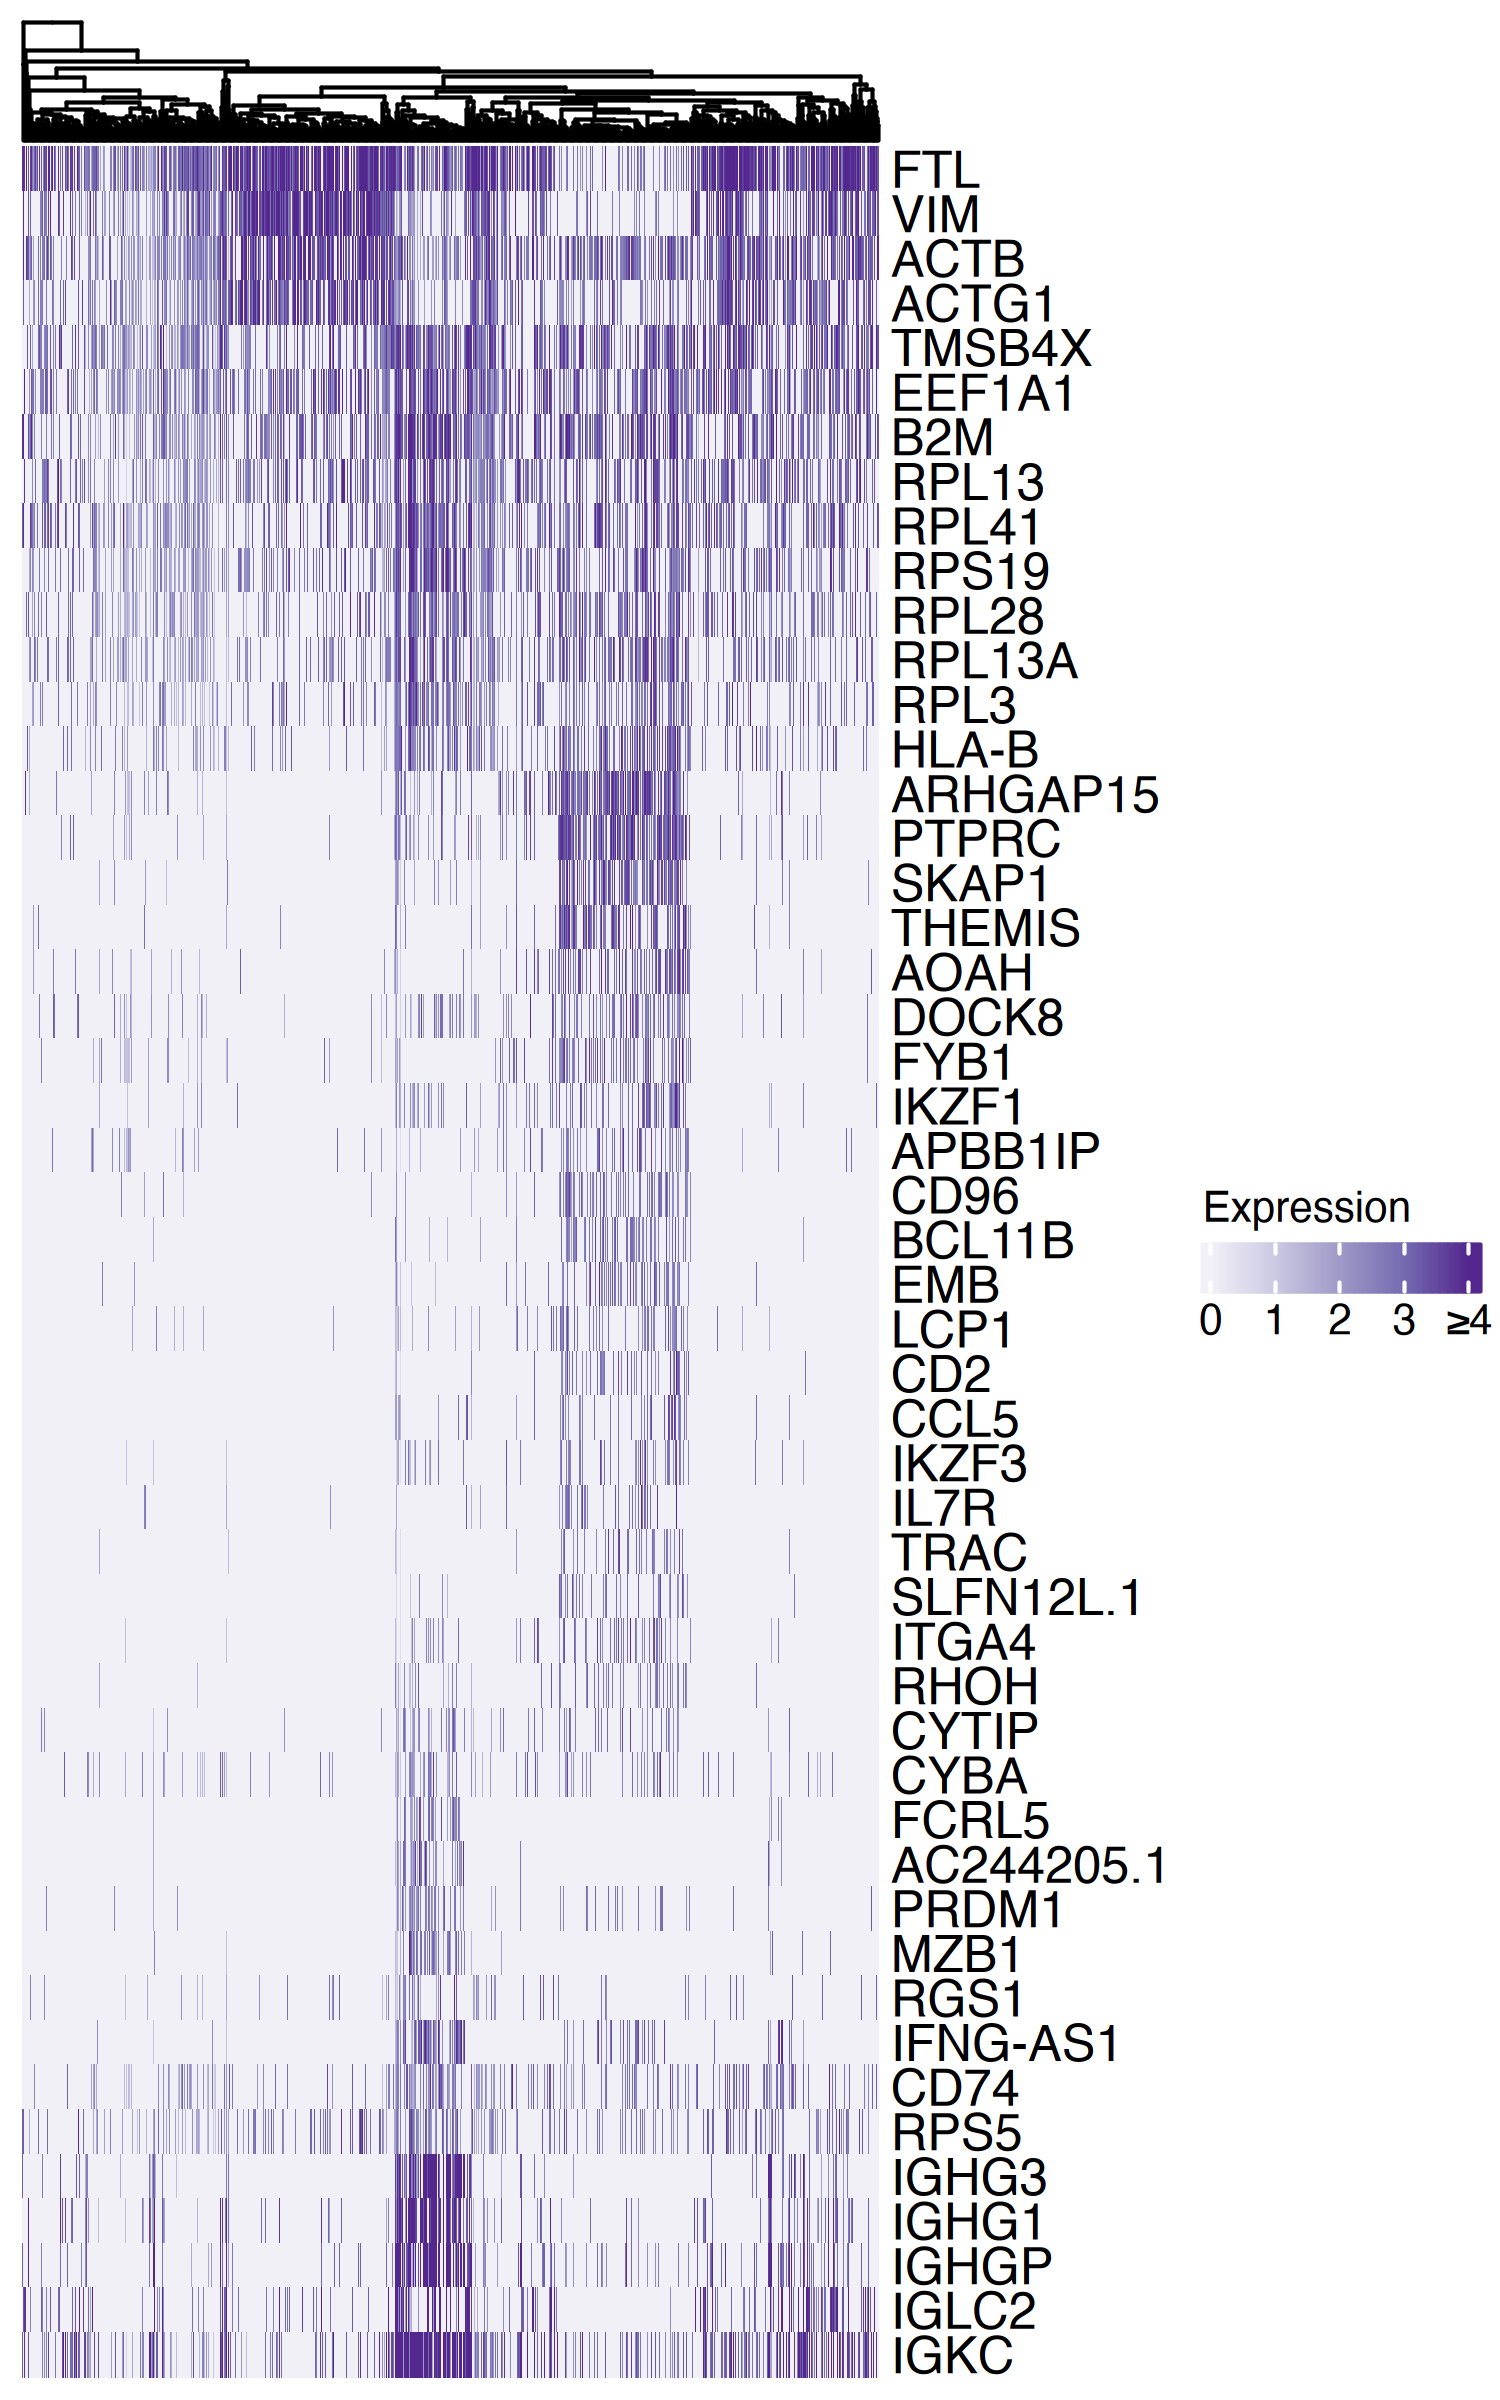

In [33]:
options(repr.plot.width=5, repr.plot.height=8, repr.plot.res = 300, warn = -1)

pdf("outputs/figures/figure3f.pdf",width=5,height=8)

ht = Heatmap(name = "Expression", cluster2_heatmap_mat, 
        cluster_columns = dend,
        row_order = rev(get_order(o2, dim = 1)),
        col = circlize::colorRamp2(breaks = c(0, 1, 2, 3, 4), 
                                   colors = RColorBrewer::brewer.pal(n = 5, name = "Purples")), 
        show_column_names = FALSE, 
        row_names_gp = gpar(fontface = "italic"),
        use_raster = FALSE,
       heatmap_legend_param = list(direction="horizontal", labels = c('0', '1', '2', '3', '≥4')))

draw(ht)

dev.off()

ht

options(warn = 0)

Next, let's examine the expression of the corrected up-signature and FIND-seq gene signature across all clusters in the dataset. To visualize sample heterogeneity, we'll first group nuclei into sample-cluster pseudobulks.

In [34]:
ag_human = AggregateExpression(human, assays = 'RNA', group.by = c('seurat_clusters', 'sample'), return.seurat = TRUE)
pseudobulk_mat <- LayerData(ag_human, assay = 'RNA', layer = 'data', features = findseq_human)

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.
First group.by variable `seurat_clusters` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Centering and scaling data matrix



Now plot the heatmap:

pdf 
  2

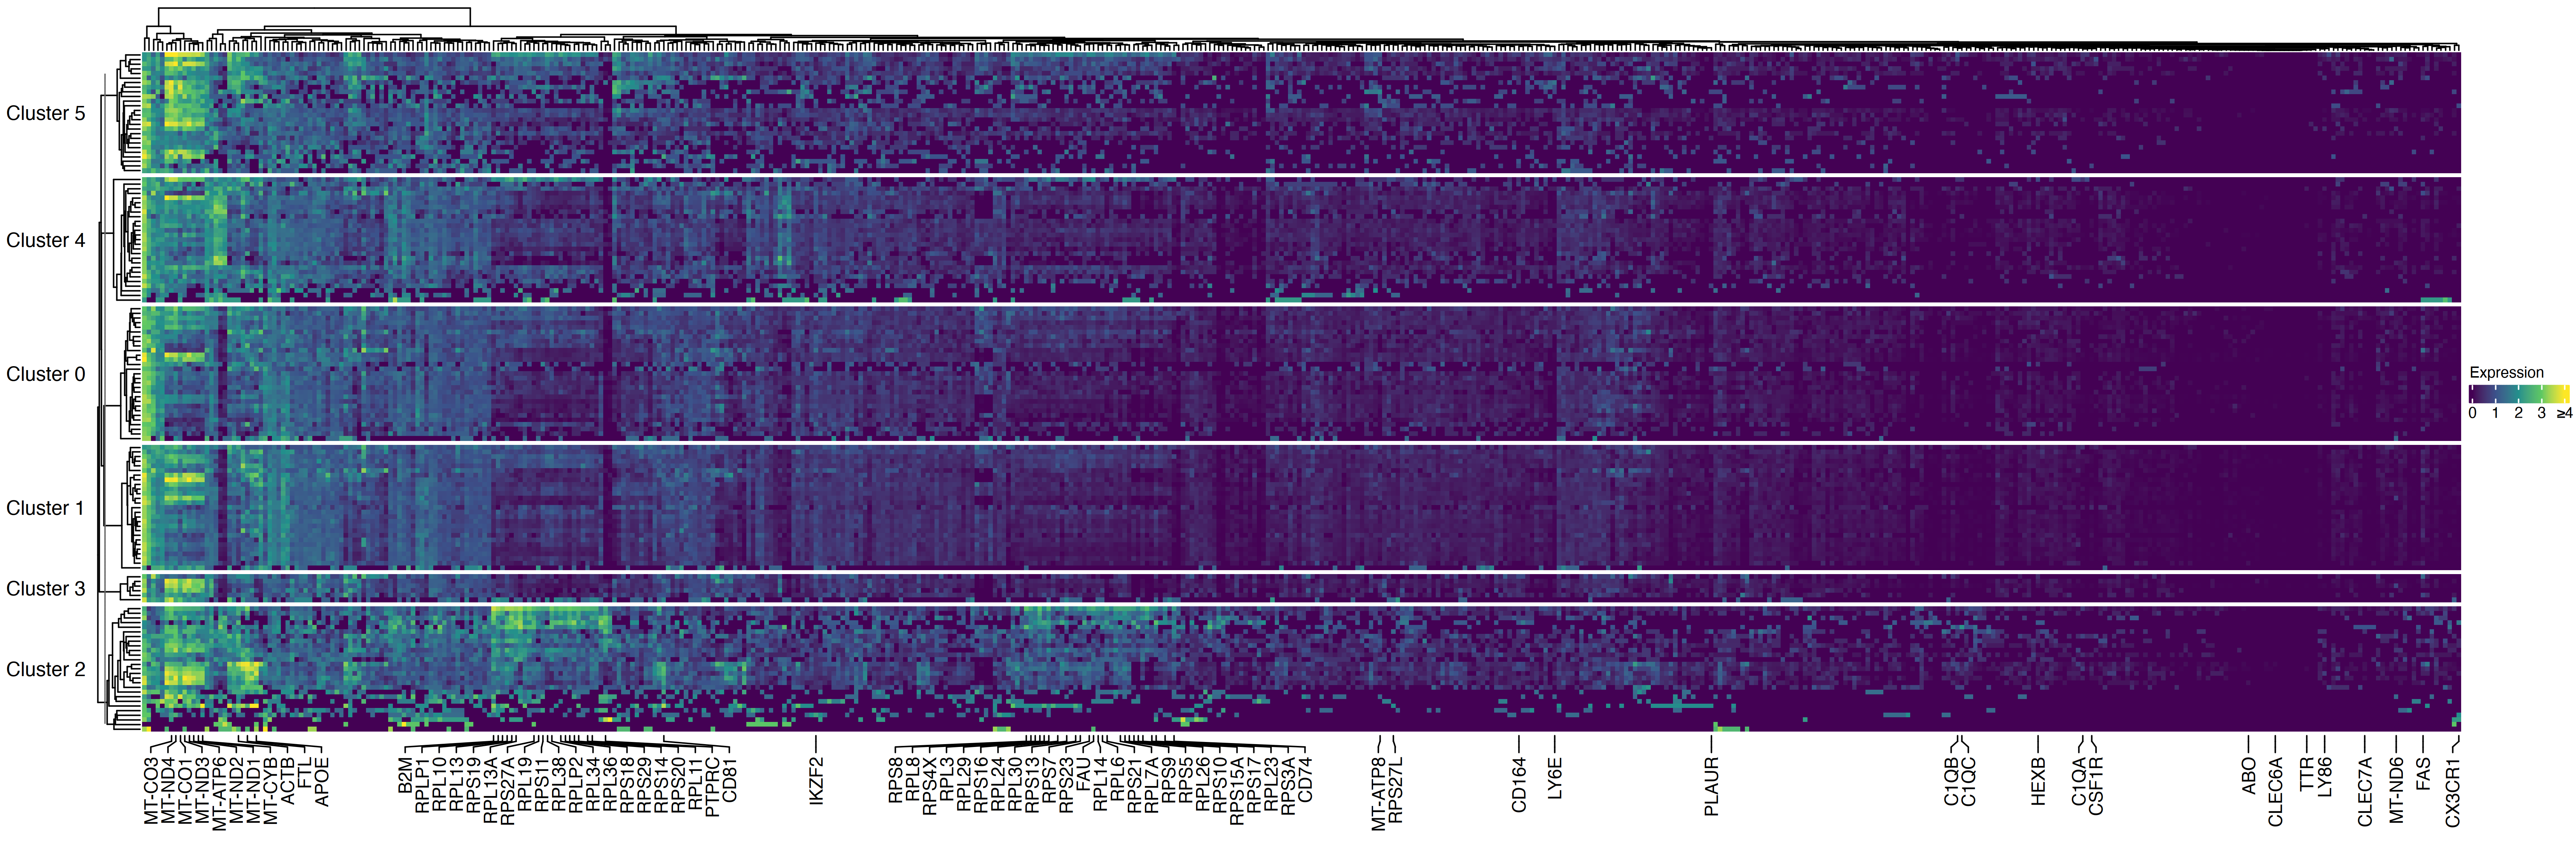

In [35]:
options(repr.plot.width=24, repr.plot.height=8, repr.plot.res = 300, warn = -1)

labels <- c("FTL", "ACTB", "APOE", "B2M", "ABO", "C1QA", "C1QB", "C1QC", "CD74", "CD164", "CD81", 'CLEC6A', 'CLEC7A', 'CSF1R', 'CSF2R', 'CX3CR1', 'FAS', 'FAU', 'HLA-DQB2', 'HEXB', 'IKZF2', 
            'PTPRC', 'TTR', 'LY6S', 'LY6E', 'LY86', 'PLAUR', 'RPL10', 'RPL11', 'RPL13', 'RPL13A', 'RPL14', 'RPL19', 'RPL23', 'RPL23A', 'RPL24', 'RPL26', 'RPL29', 'RPL3', 'RPL30', 'RPL31', 'RPL32', 'RPL34',
           'RPL35A', 'RPL36', 'RPL38', 'RPL39', 'RPL6', 'RPL7A', 'RPL8', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS13', 'RPS14', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS20', 'RPS21', 
           'RPS23', 'RPS27A', 'RPS27L', 'RPS29', 'RPS3A', 'RPS4X', 'RPS5', 'RPS7', 'RPS8', 'RPS9', 'MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-C02', 'MT-CO3', 'MT-ND1', 'MT-ND2', 'MT-CYB', 'MT-ND3', 'MT-ND4', 'MT-ND6')
indices <- match(labels, colnames(t(pseudobulk_mat)))

ha = columnAnnotation(markers = anno_mark(at = indices, 
    labels = labels, 
    labels_gp = gpar(fontface = "italic"), side = "right"))

png("outputs/figures/findseq_pseudobulkheatmap.png",width=24,height=8,units="in",res=1200)

ht <- Heatmap(name = 'Expression', t(pseudobulk_mat), col = circlize::colorRamp2(breaks = c(0, 1, 2, 3, 4), colors = viridis(option = 'viridis', n = 5)),
        bottom_annotation = ha, show_column_names = FALSE,
       row_split = gsub("g", "Cluster ", ag_human$seurat_clusters), 
              row_title_rot = 0, 
              show_row_names = FALSE,
      heatmap_legend_param = list(direction = 'horizontal', at = c(0, 1, 2, 3, 4), labels = c('0', "1", "2", "3", "≥4")))

draw(ht)

dev.off()

ht

options(warn = 0)

Lastly, let's examine expression of the corrected up-signature gene set across all clusters in the dataset. To visualize sample heterogeneity, we'll first group nuclei into sample-cluster pseudobulks.

In [36]:
pseudobulk_mat <- LayerData(ag_human, assay = 'RNA', layer = 'data', features = human_corrected_up_signature)

pdf 
  2

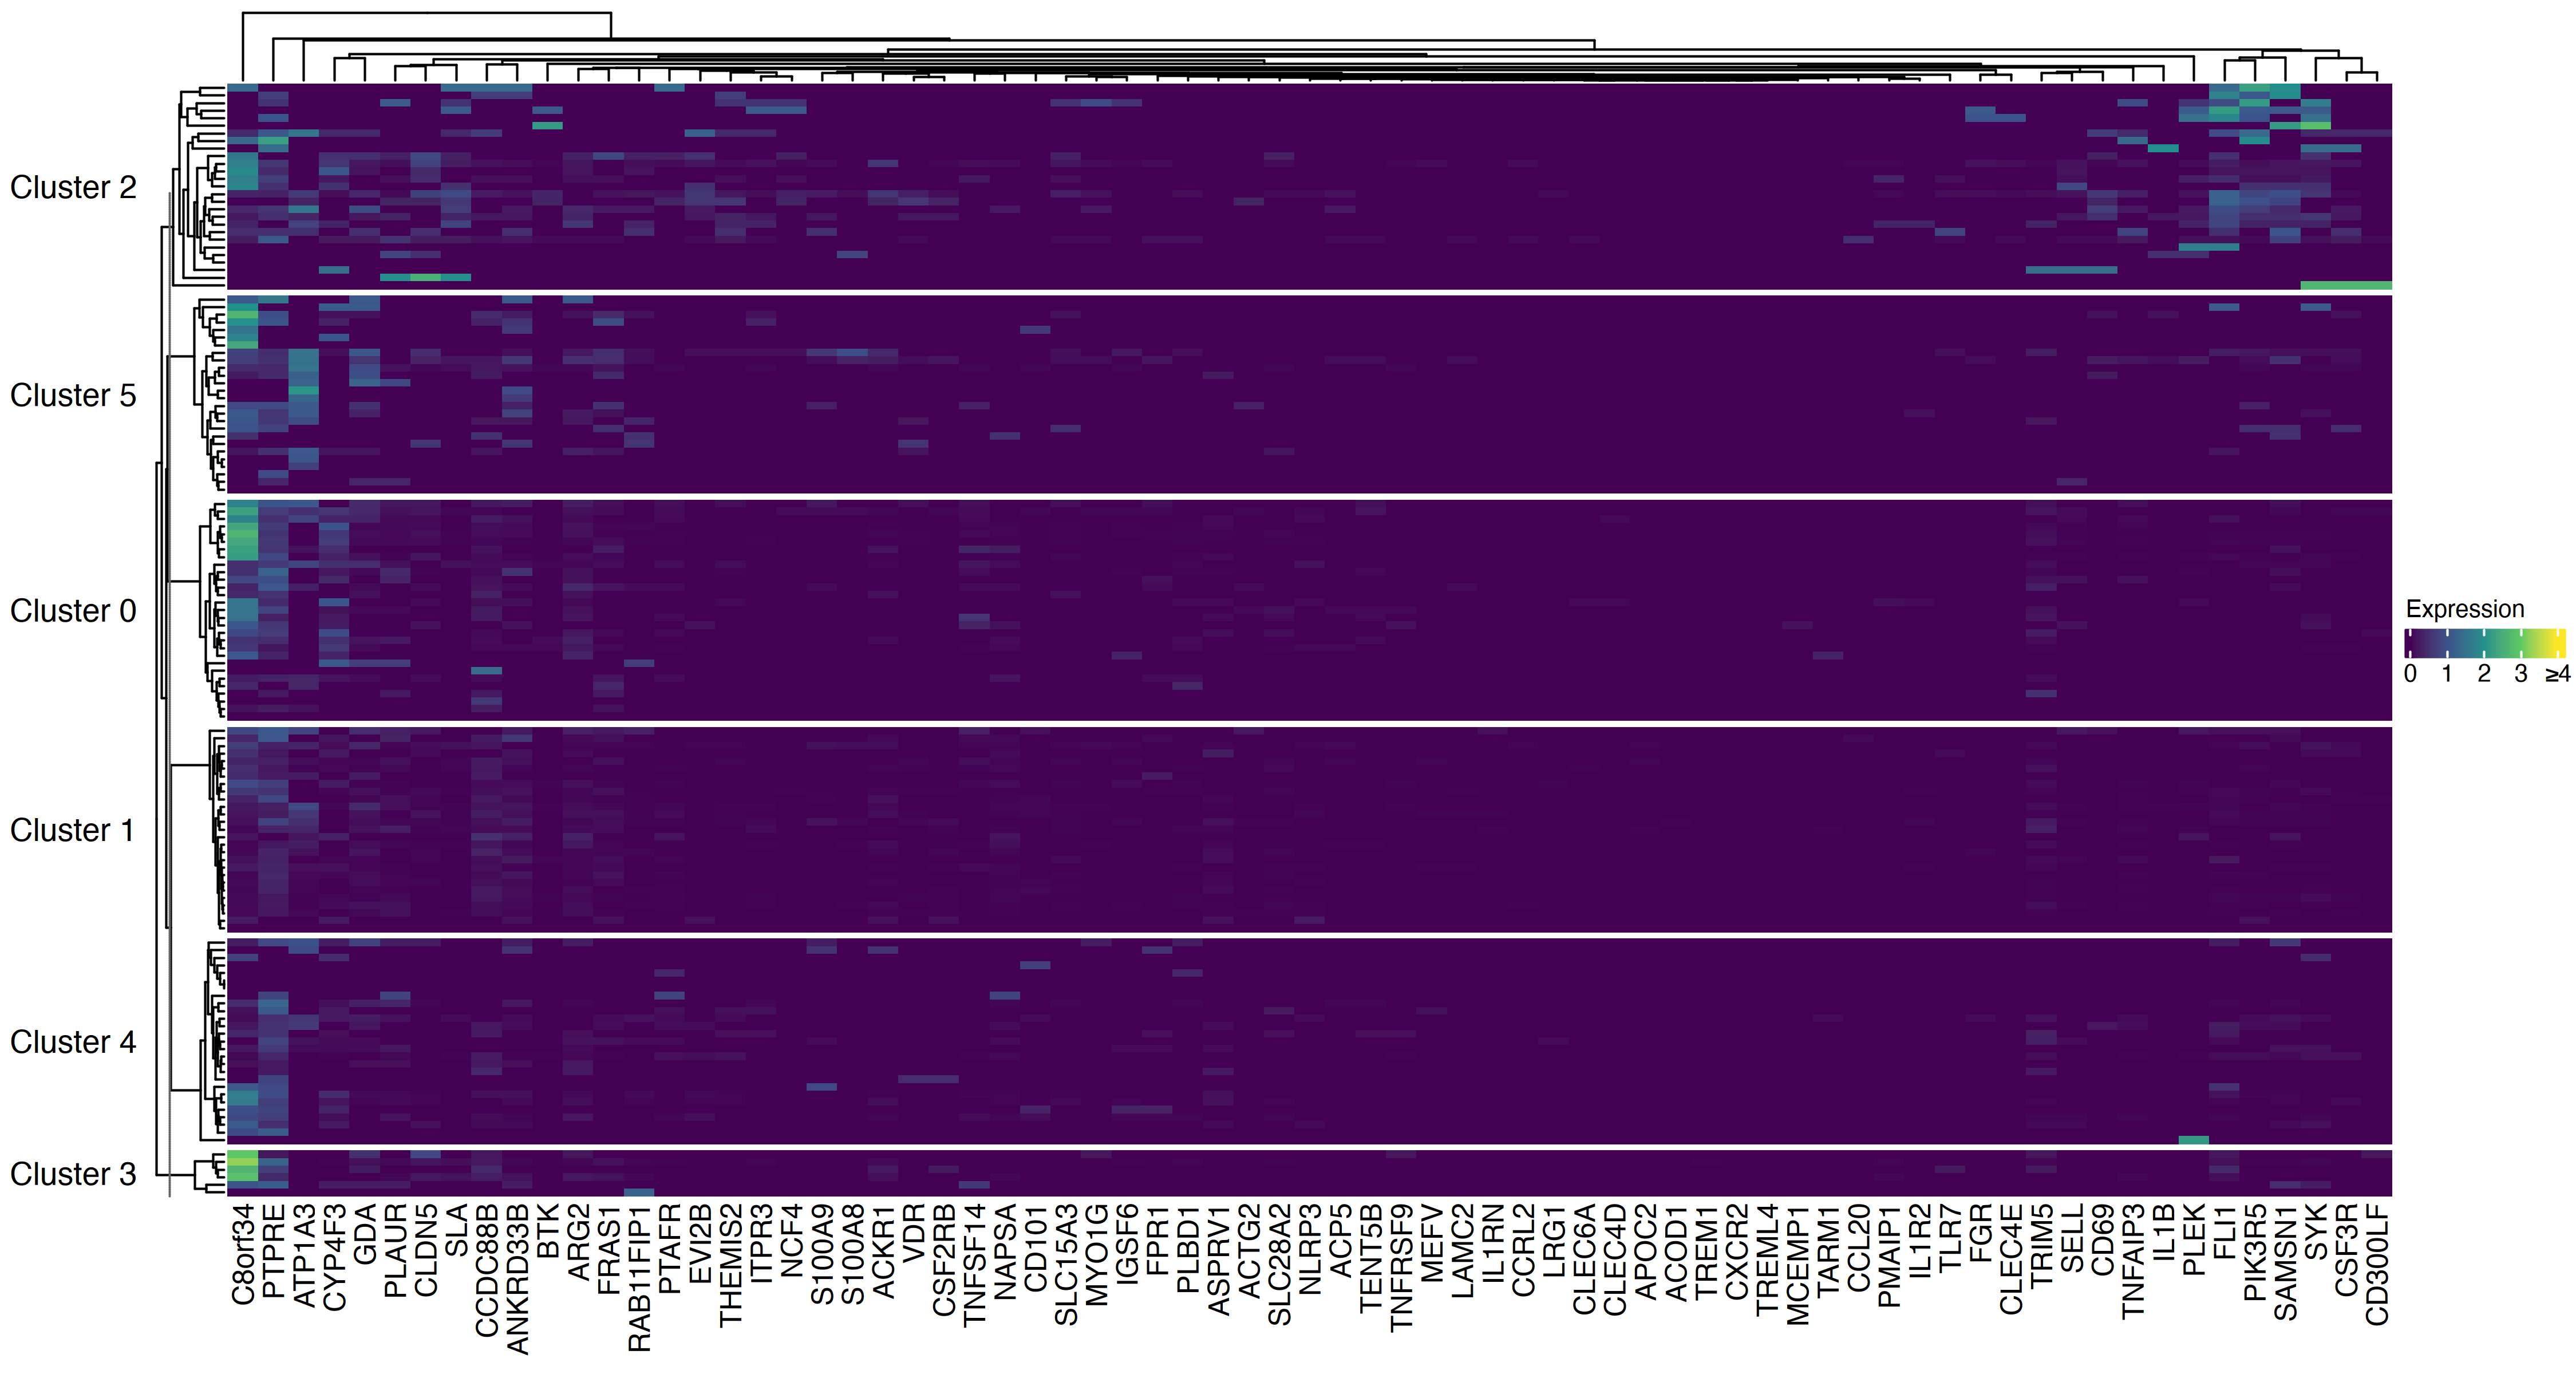

In [37]:
options(repr.plot.width=15, repr.plot.height=8, repr.plot.res = 300, warn = -1)

png("outputs/figures/corrected_upsignature_pseudobulkheatmap.png",width=15,height=8,units="in",res=1200)

ht <- Heatmap(name = 'Expression', t(pseudobulk_mat), col = circlize::colorRamp2(breaks = c(0, 1, 2, 3, 4), colors = viridis(option = 'viridis', n = 5)),
       row_split = gsub("g", "Cluster ", ag_human$seurat_clusters), 
              row_title_rot = 0, 
              show_row_names = FALSE,
              show_column_names = TRUE,
              column_names_gp = gpar(fontface = "italic"),
              
      heatmap_legend_param = list(direction = 'horizontal', at = c(0, 1, 2, 3, 4), labels = c('0', "1", "2", "3", "≥4")))

draw(ht)

dev.off()

ht

options(warn = 0)

We can see there is little expression of the corrected up-signature genes across any of the clusters in this dataset, and there is certainly no consistent elevation across samples. 

Save the final Seurat object:

In [38]:
saveRDS(human, 'outputs/combined_human_final_seurat_object.rds')

In [39]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrastr_1.0.2         cowplot_1.1.3         harmony_1.2.3        
 [4] svglite_2.1.3         Matrix_1.6-5          ggrepel_0.9.6        
 [7] seriation_1.5.7       dendextend_1.19.0     ComplexHeatmap_2.18.0
[10] orthogene_1.8.0       presto_1.0.0          data.table_1.15.4    
[13] Rcpp_1.0.13-1         viridis_0.6.5         viridisLite_0.4.2    
[16] tidyr_1.3.1           dplyr_1.1.4           ggpubr_0.6.0         
[19] ggplot2_3.5.1         readxl_1.4.3       

In [40]:
version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             